In [1]:
import logging
from pathlib import Path

import SimpleITK as sitk
from clinical_evaluation.registration import pipeline
from clinical_evaluation.utils import preprocess, ops
from clinical_evaluation.evaluation import metrics
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [2]:
def get_visuals(ref, pred, min_HU=-135, max_HU=215):
    """
    Generates different visuals that are useful for visual inspection such as:
    1. Difference axial image.
    2. Zoomed central axial slice.
    3. Sagittal views
    """
    visuals = {}
    windowed_ref = np.clip(ref, min_HU, max_HU)
    windowed_pred = np.clip(pred, min_HU, max_HU)
    
    difference_image = windowed_ref - windowed_pred
    
    difference_views = get_axial_sagittal_views(difference_image, min_HU, max_HU, normalize=False)
    visuals.update({f'difference_{k}': v for k, v in difference_views.items()})
        
    pred_views = get_axial_sagittal_views(windowed_pred, min_HU, max_HU)
    visuals.update(pred_views)
    
    return visuals


def get_axial_sagittal_views(image, min_HU, max_HU, zoom_factor=3, normalize=True):
    """
    Get axial and sagittal views along with zoomed axial and sagittal views. 
    zoom_factor: Gives the amount of zoom that must be provided during center crop and zoom
    """
    views = {}
    
    if normalize:
        image = image - min_HU / (max_HU - min_HU)

    center = [dim//2 for dim in image.shape]
    width = [dim//zoom_factor for dim in image.shape]
    
    crop_range = [[c - w//2, c + w//2] for c, w in zip(center, width)]
    zoomed_patch = image[crop_range[0][0]:crop_range[0][1], crop_range[1][0]:crop_range[1][1], crop_range[2][0]:crop_range[2][1]]
    views["zoomed_axial"] = zoomed_patch[zoomed_patch.shape[0]//2]
    views["zoomed_sagittal"] = np.flipud(zoomed_patch[:, :, zoomed_patch.shape[2]//2])

    views["axial"] = image[image.shape[0]//2]
    views["sagittal"] = np.flipud(image[:, :, image.shape[2]//2])
    return views


def save_and_display_visuals(visuals, save_path):
    for key, visual in visuals.items():
        f = plt.figure(figsize=(15, 15))

        if "difference" in key:
            plt.imshow(visual,  cmap='coolwarm', vmin=-350, vmax=350)
            cb = plt.colorbar(orientation="horizontal",anchor=(1.0,0.0), ticks=[-350, 0, 350], fraction=0.03)
            cb.ax.tick_params(labelsize=30)

        else:
            plt.imshow(visual, cmap='gray')

        plt.axis('off')

        plt.savefig(f"{save_path}_{key}.png", pad_inches=0, bbox_inches='tight')
        plt.show()

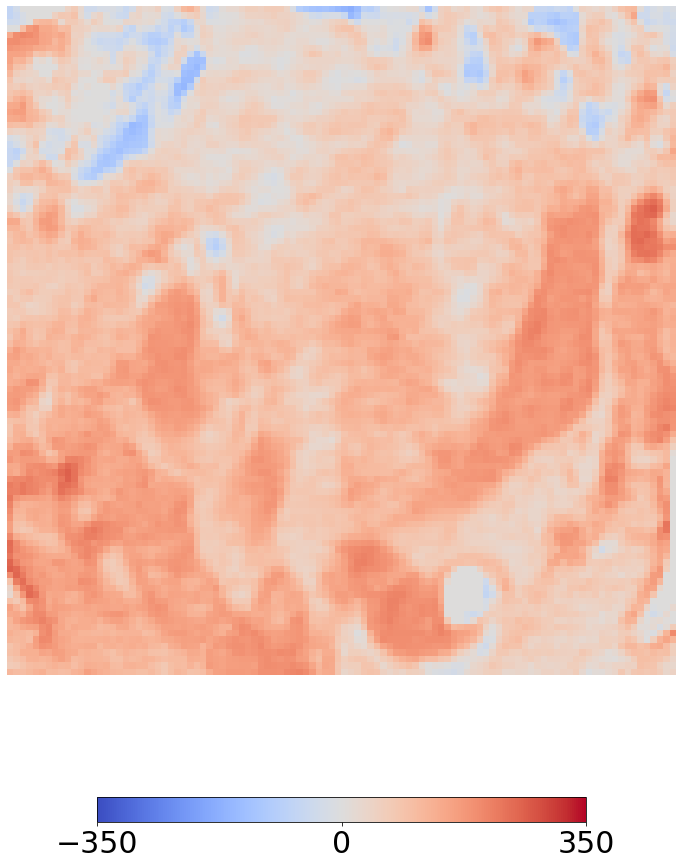

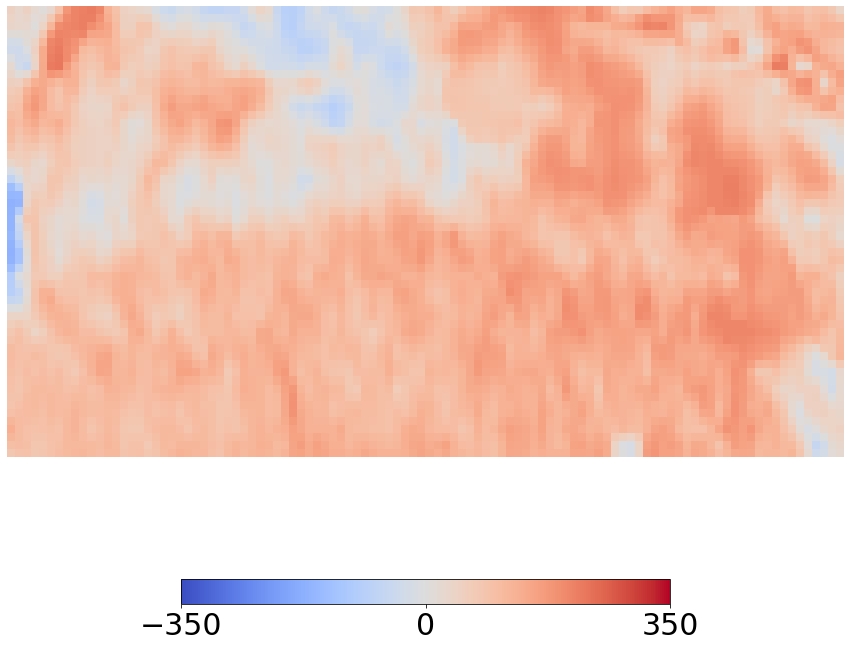

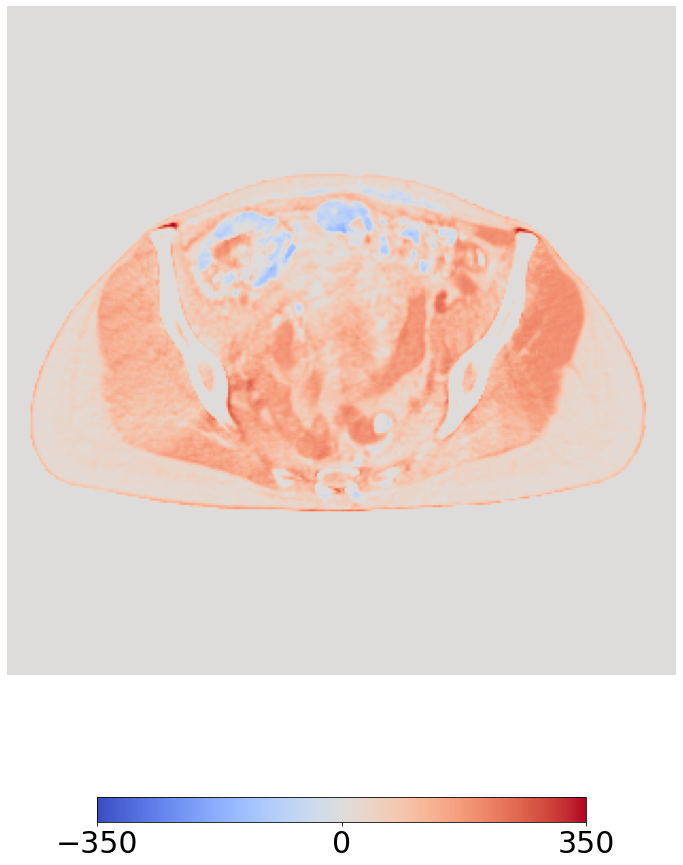

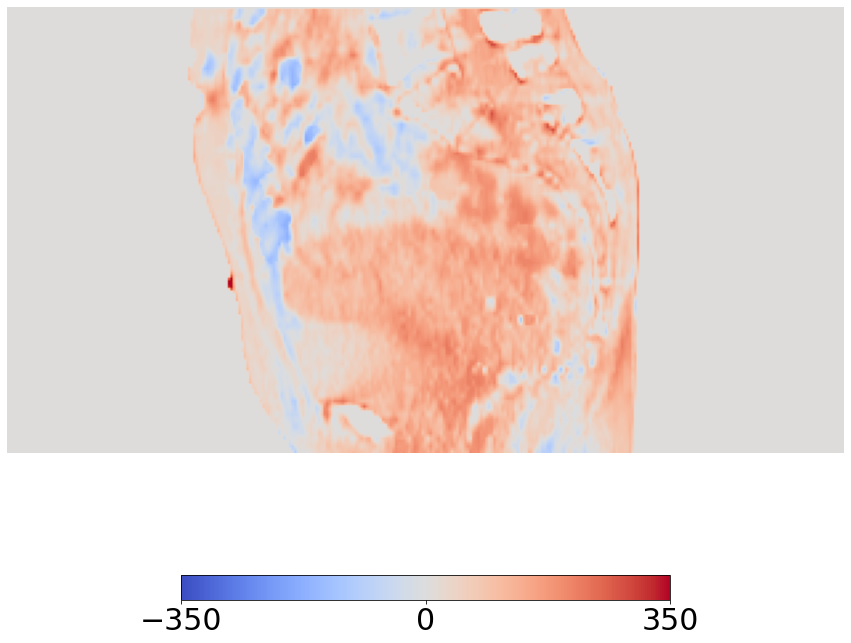

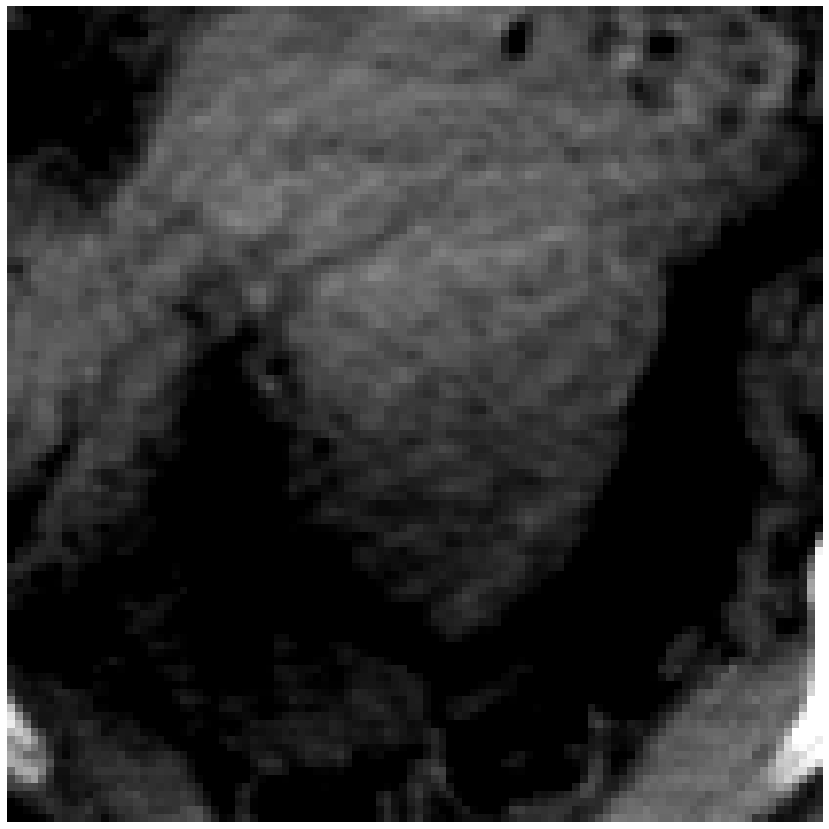

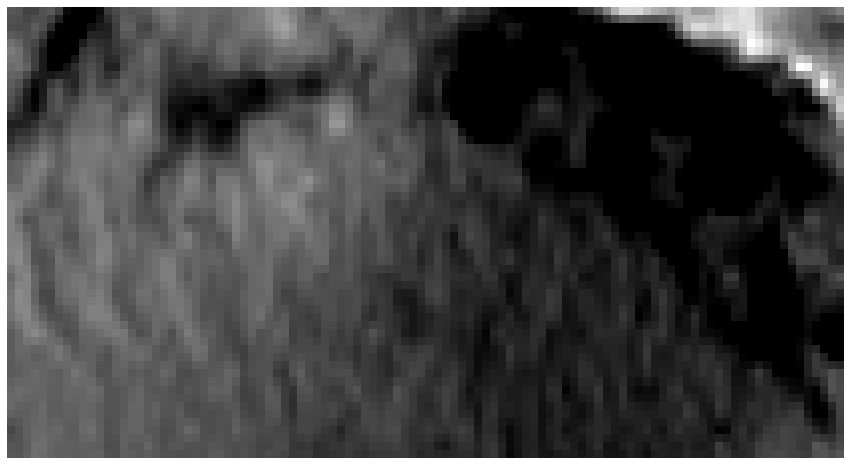

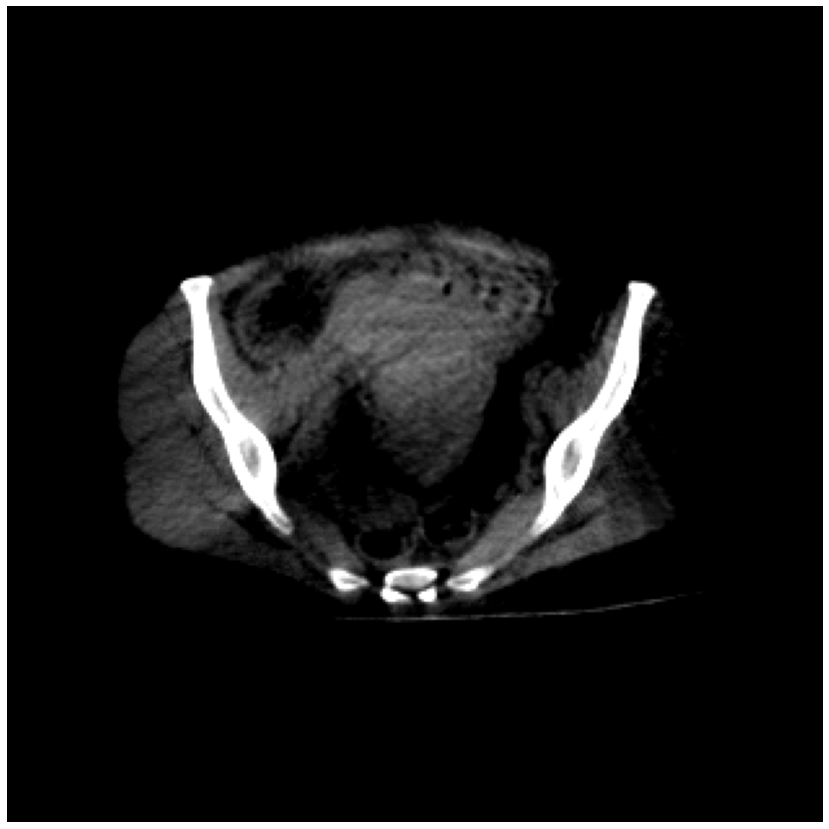

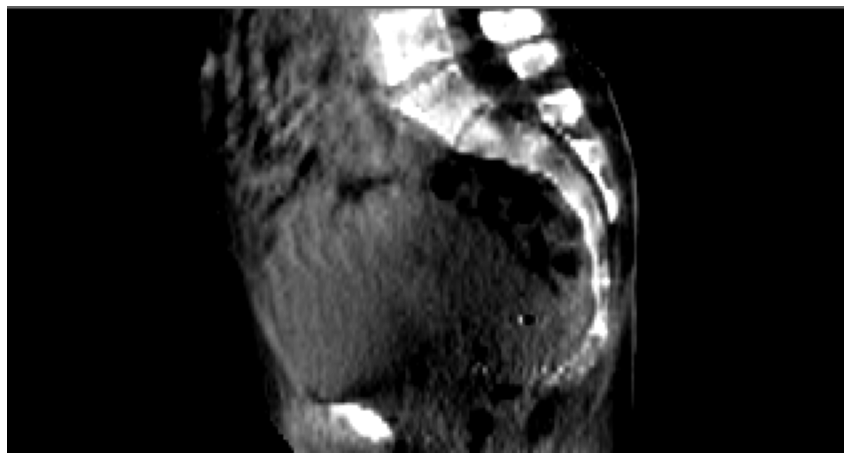

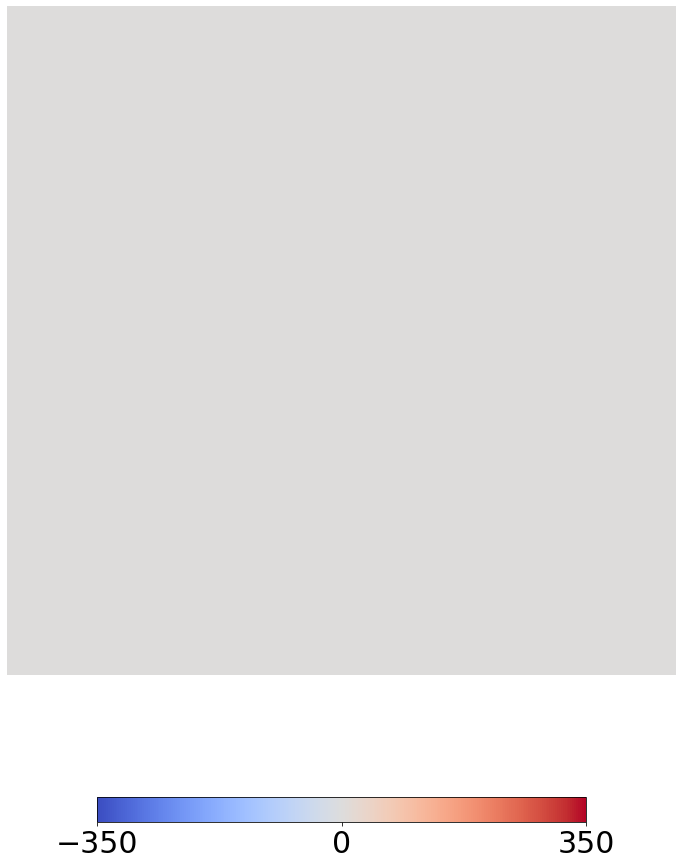

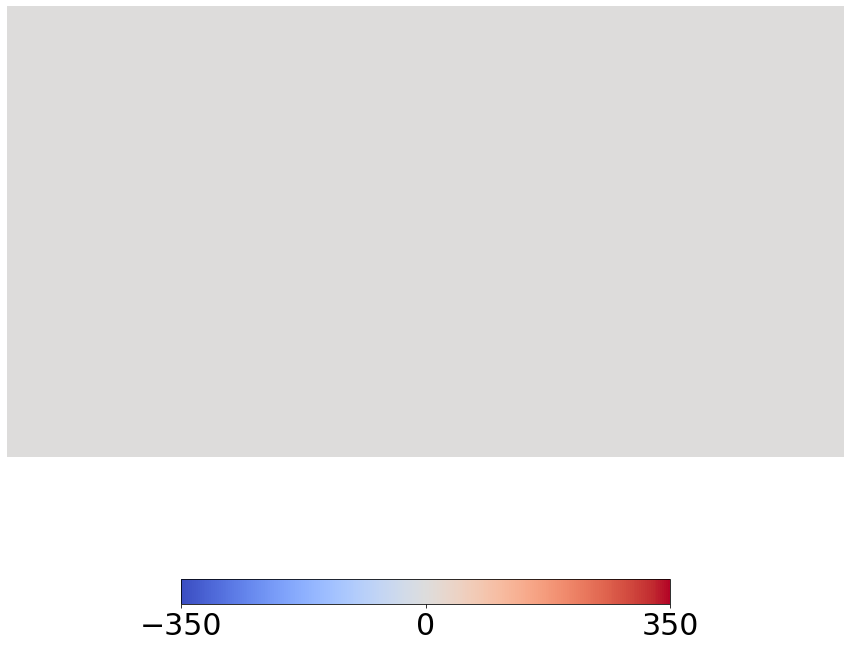

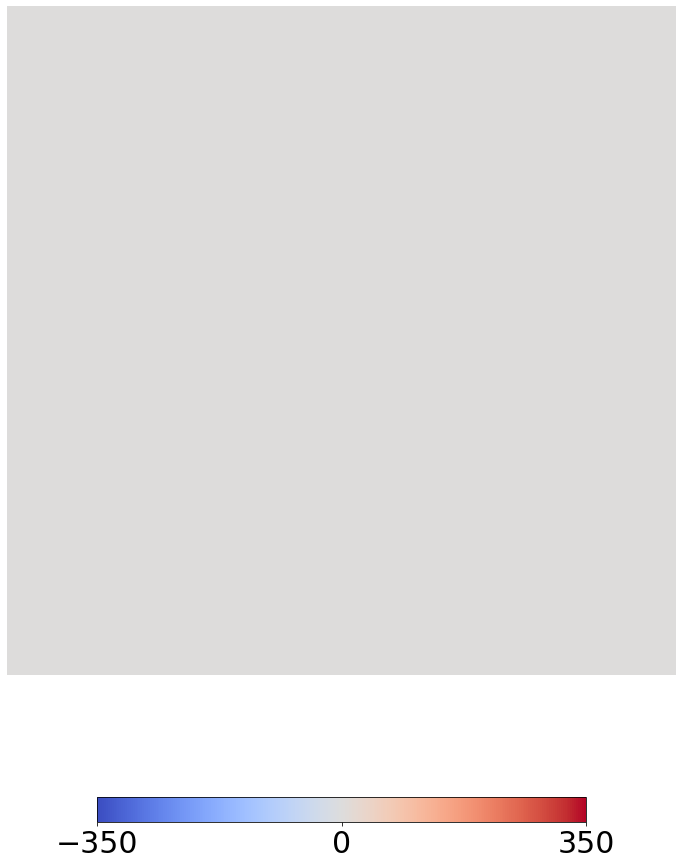

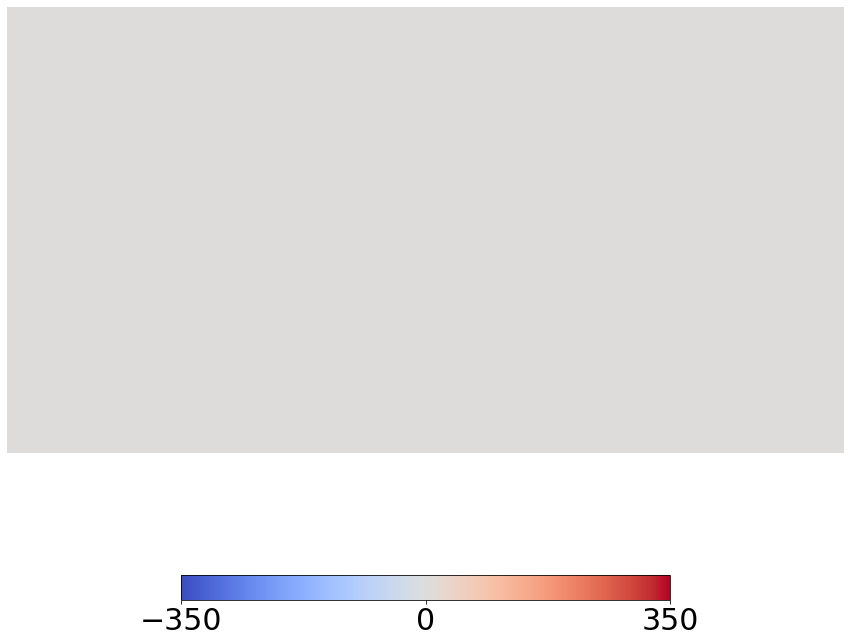

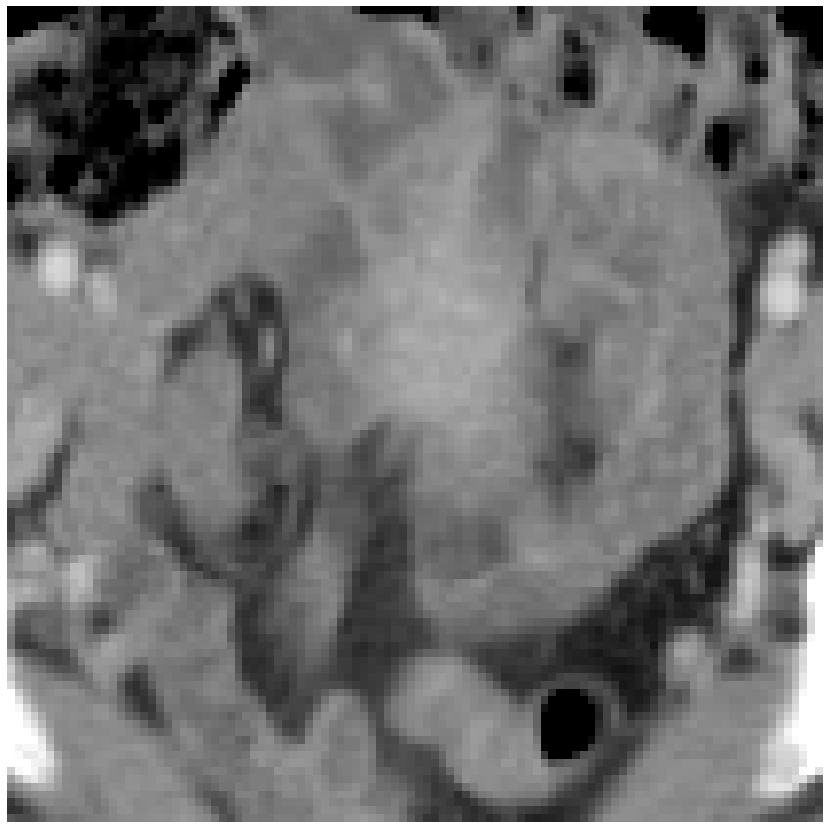

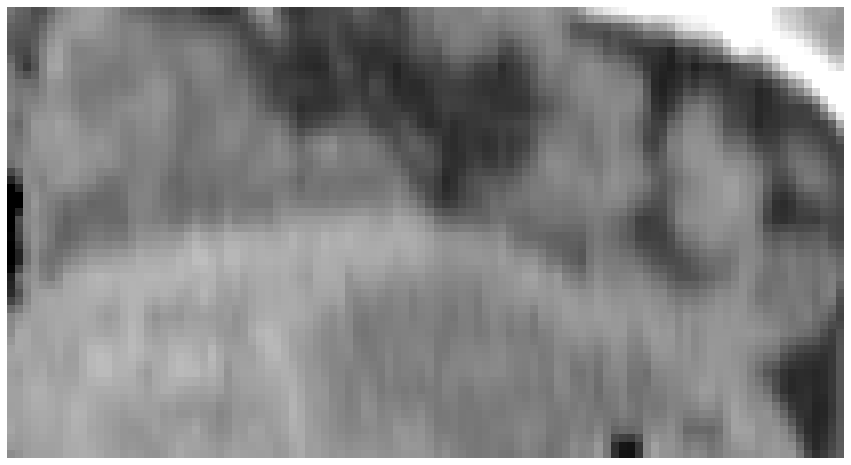

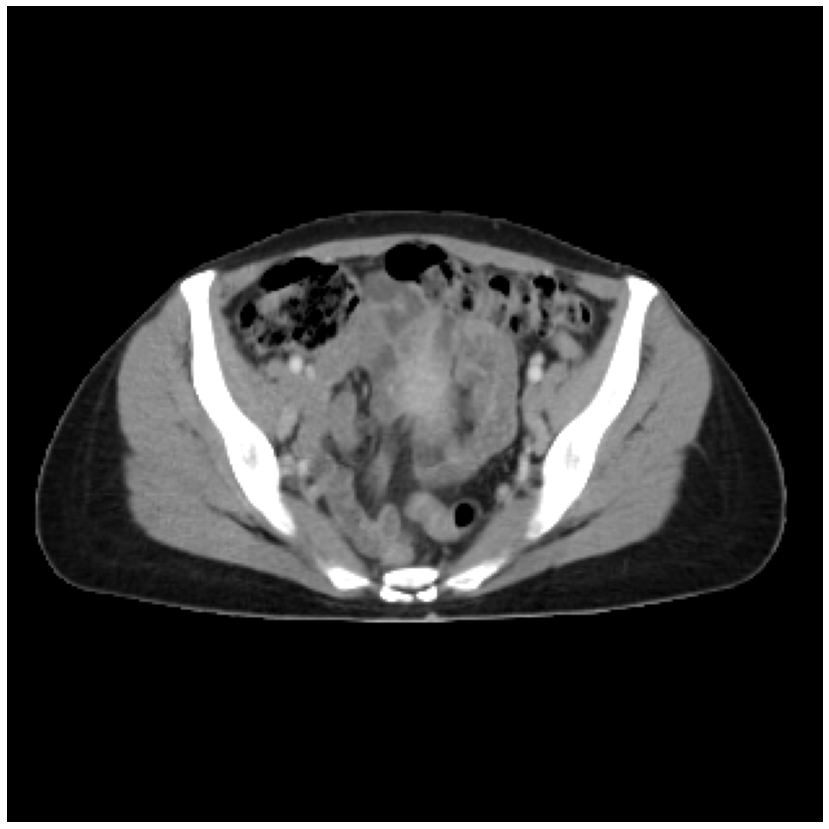

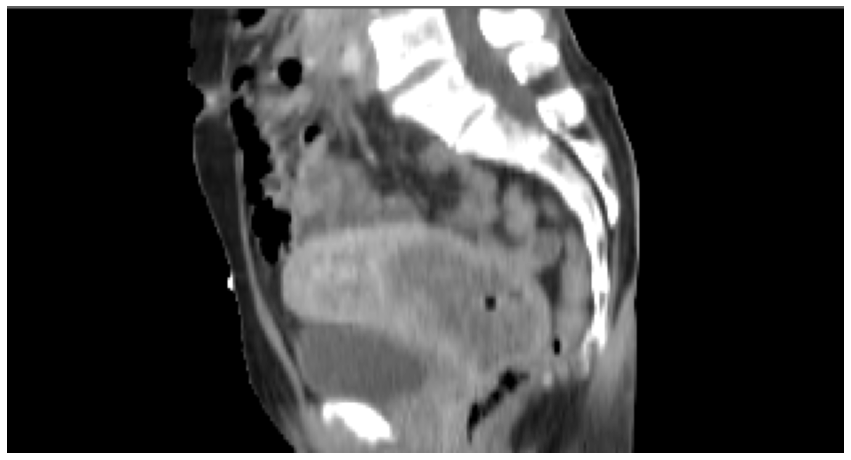

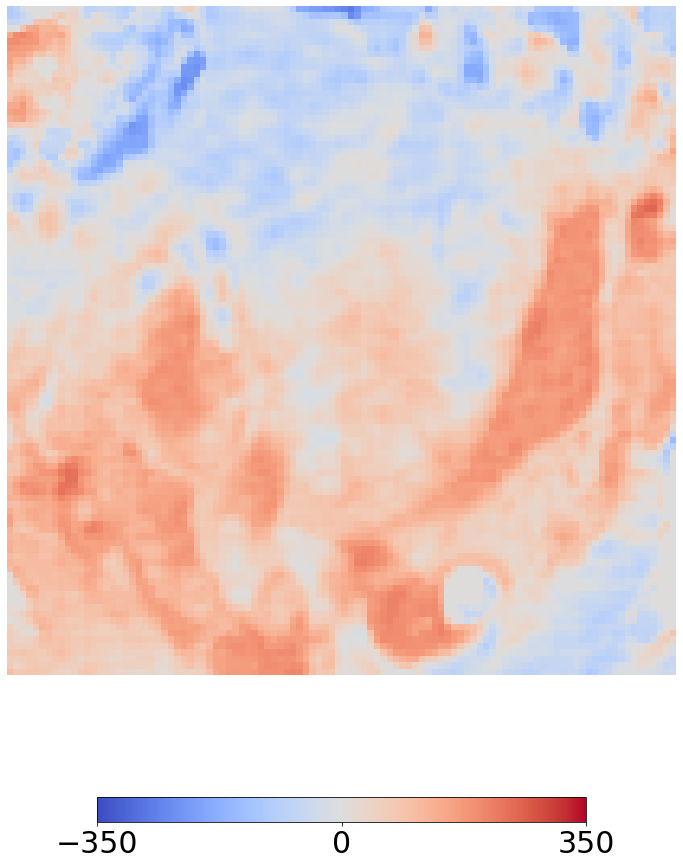

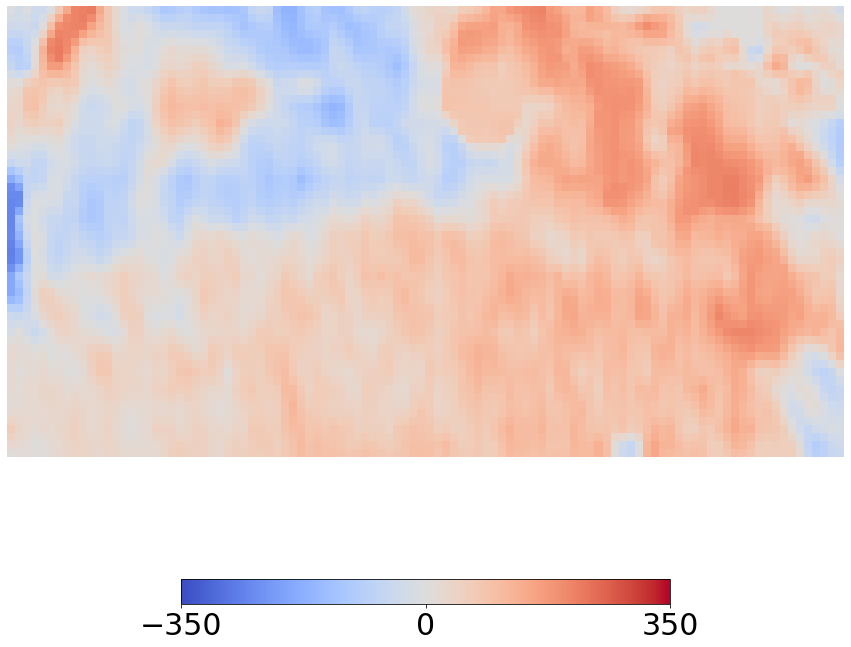

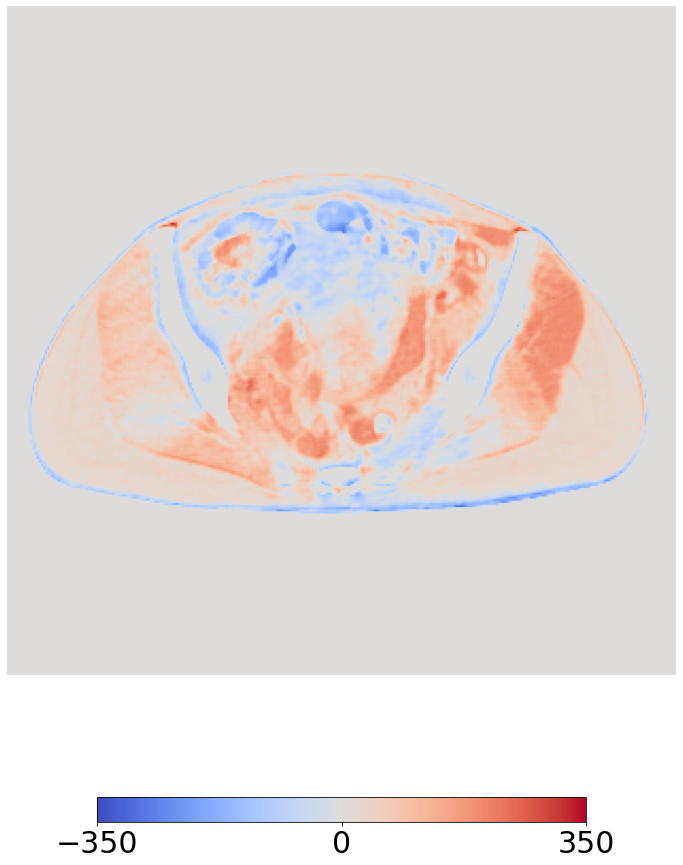

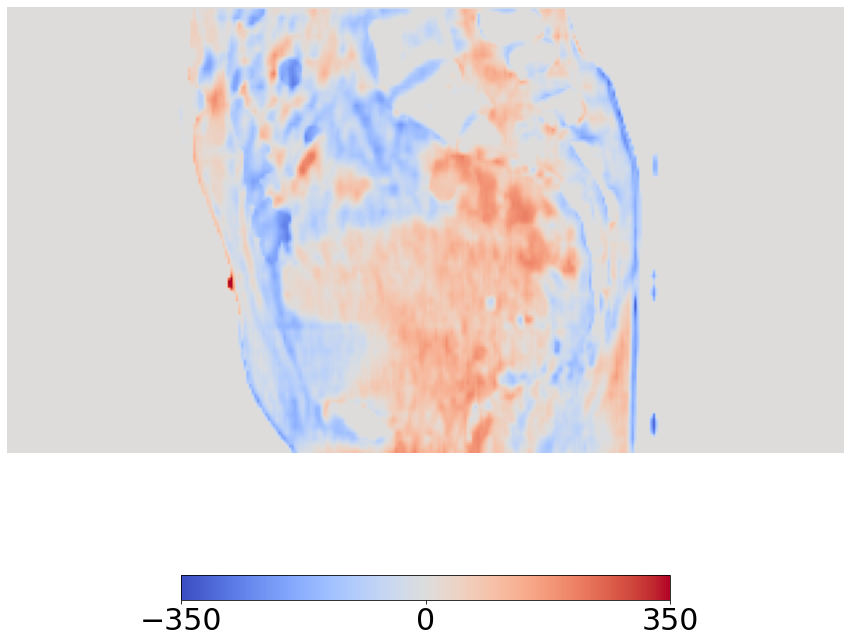

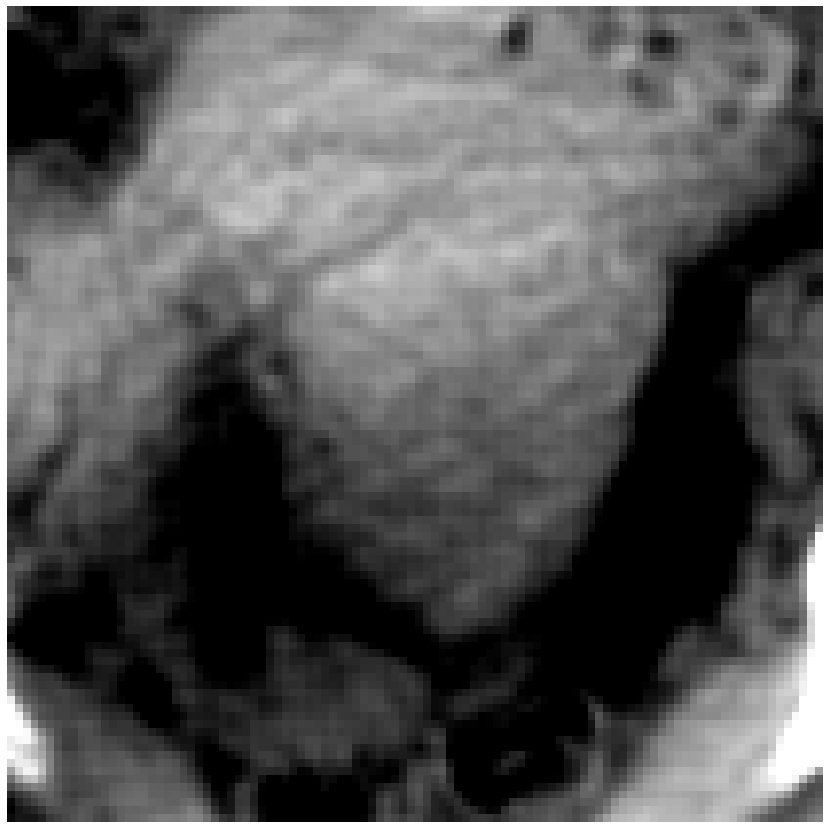

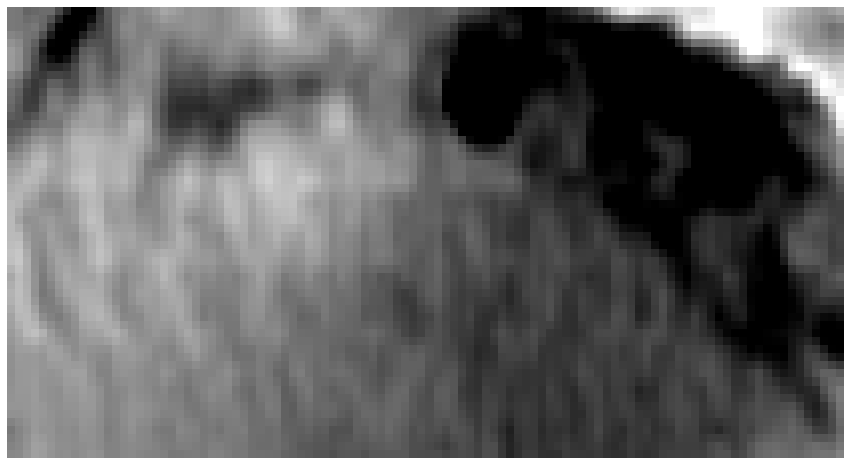

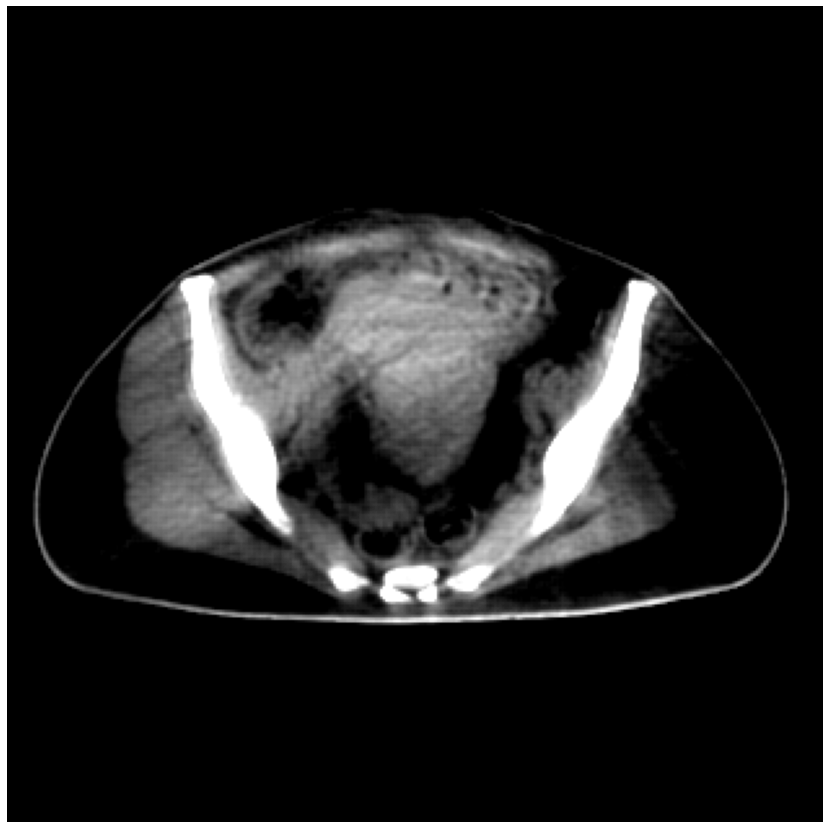

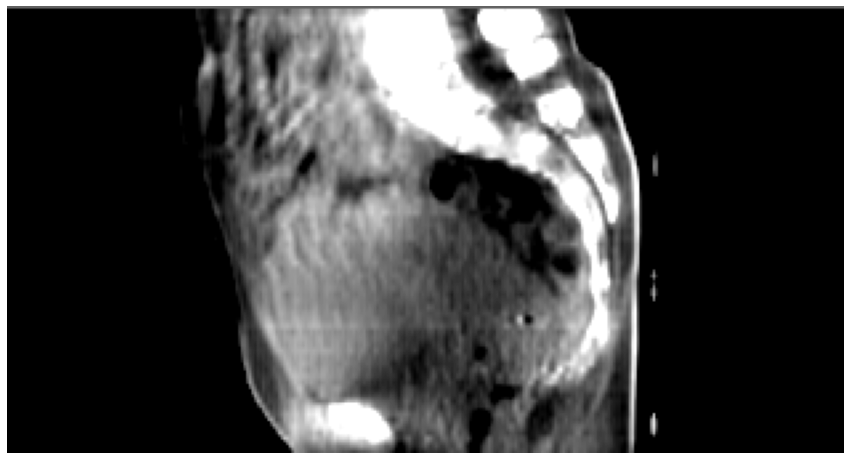

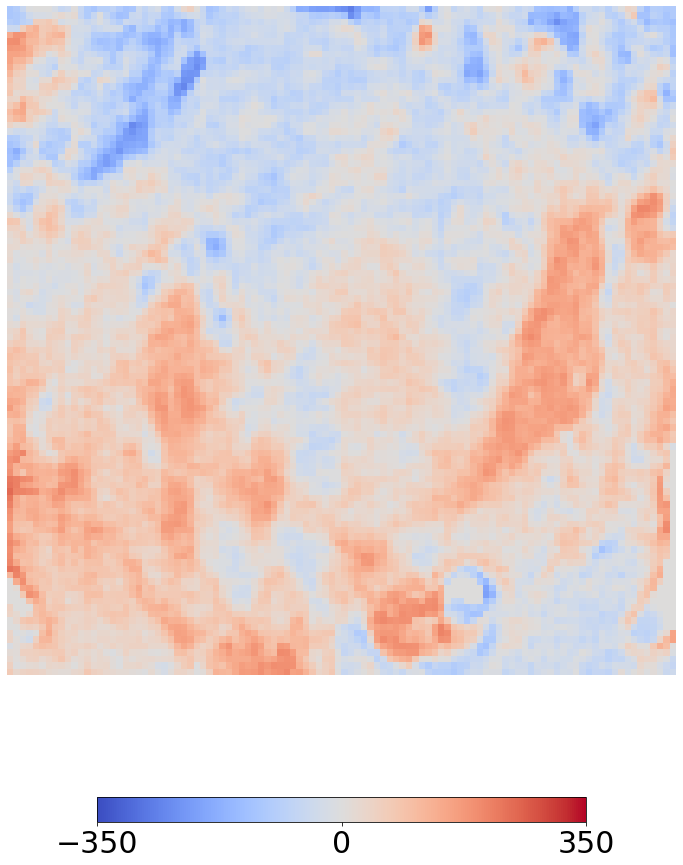

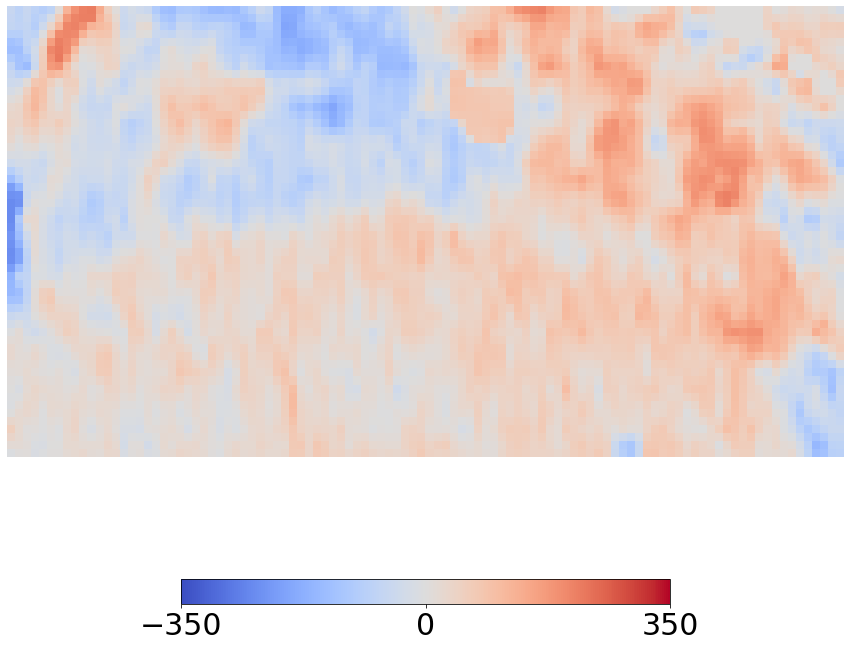

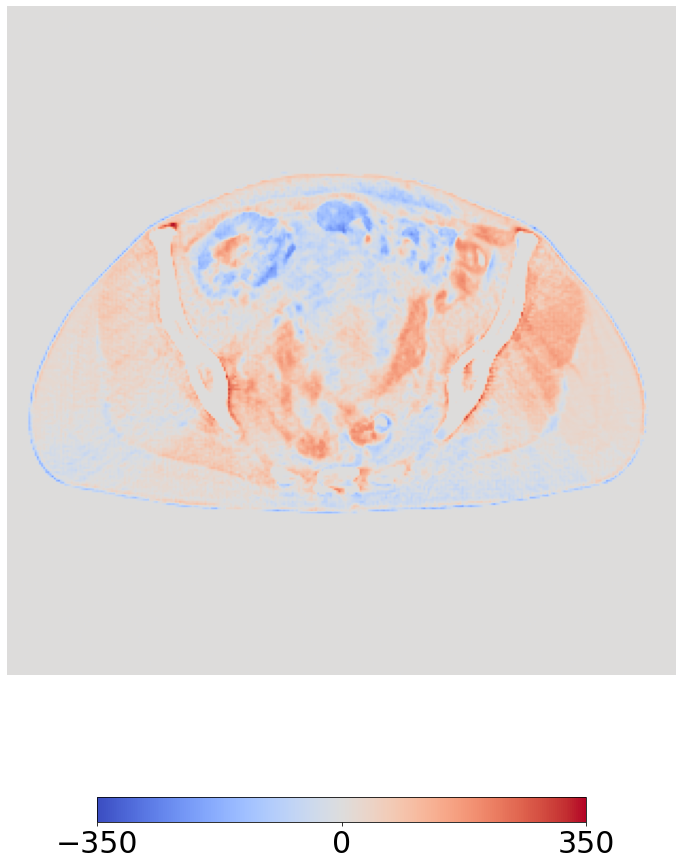

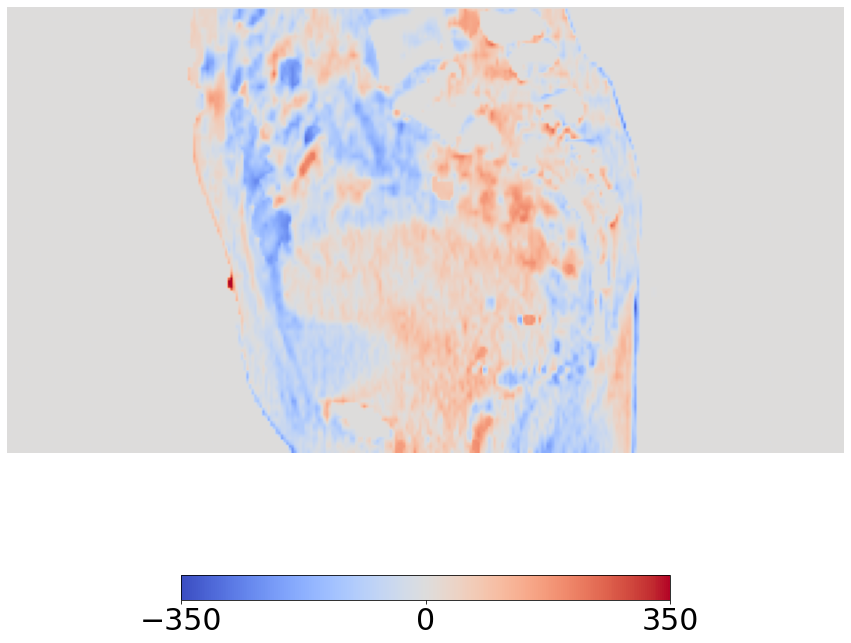

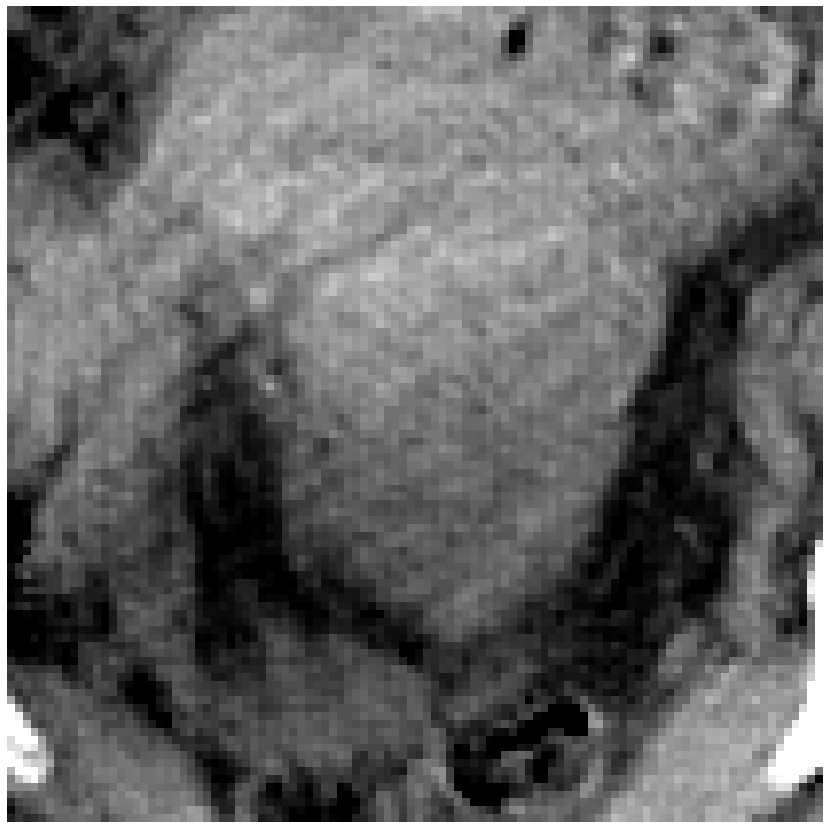

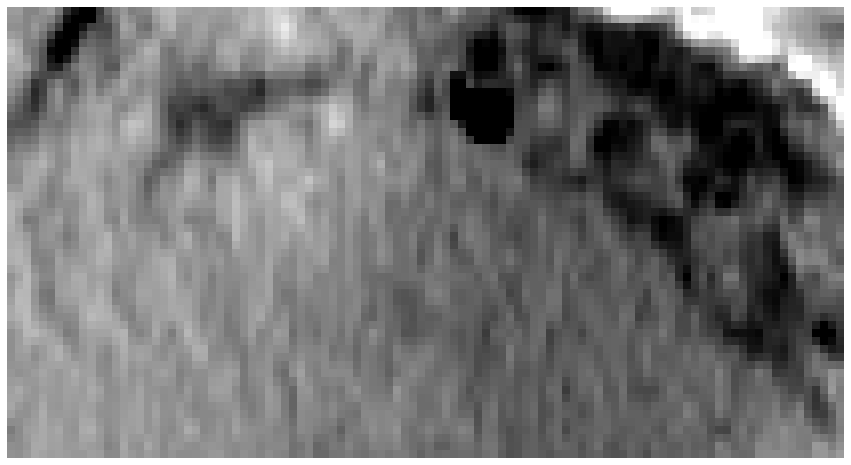

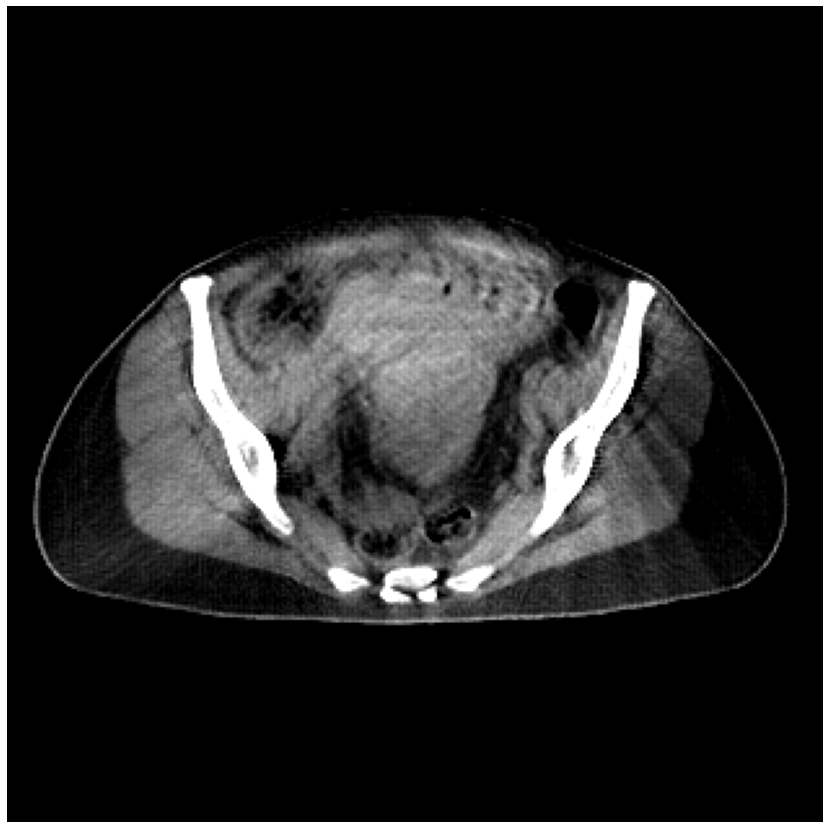

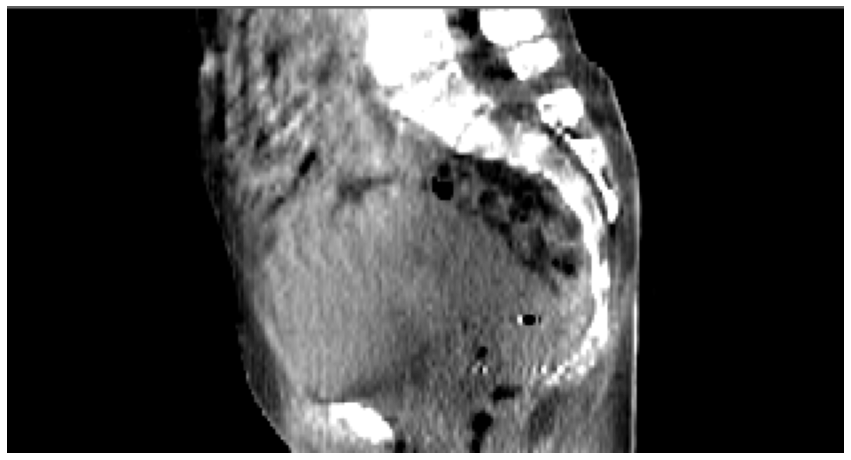

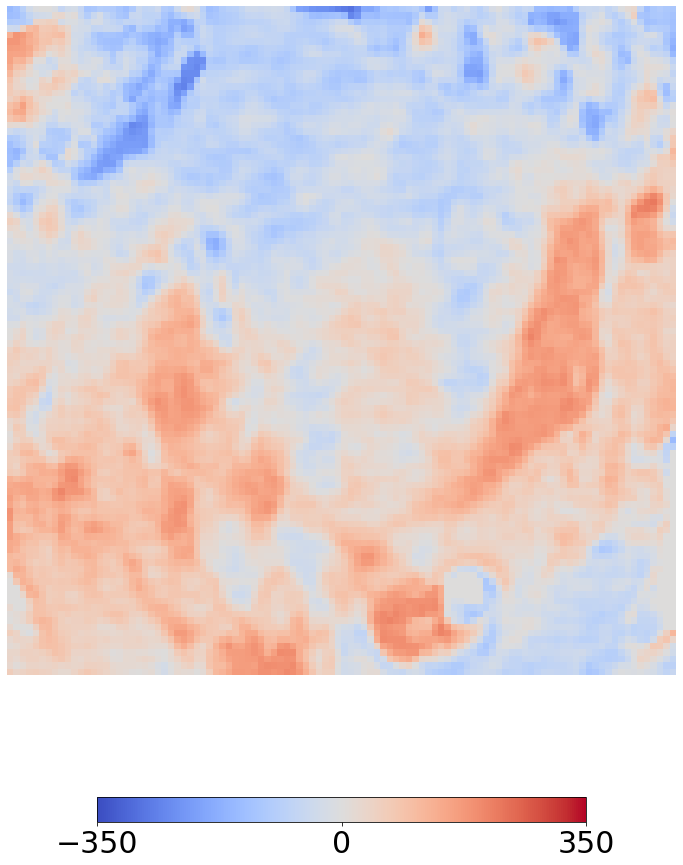

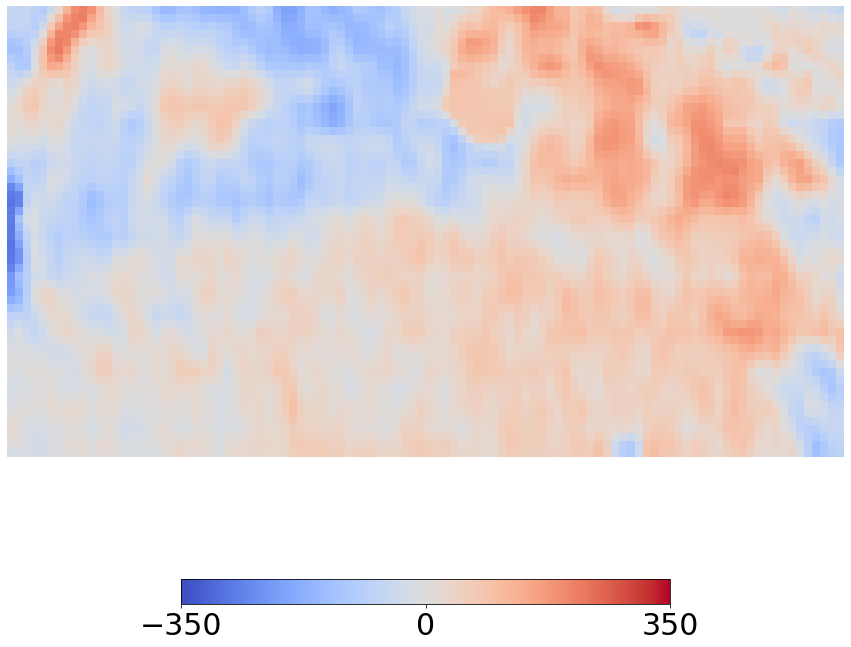

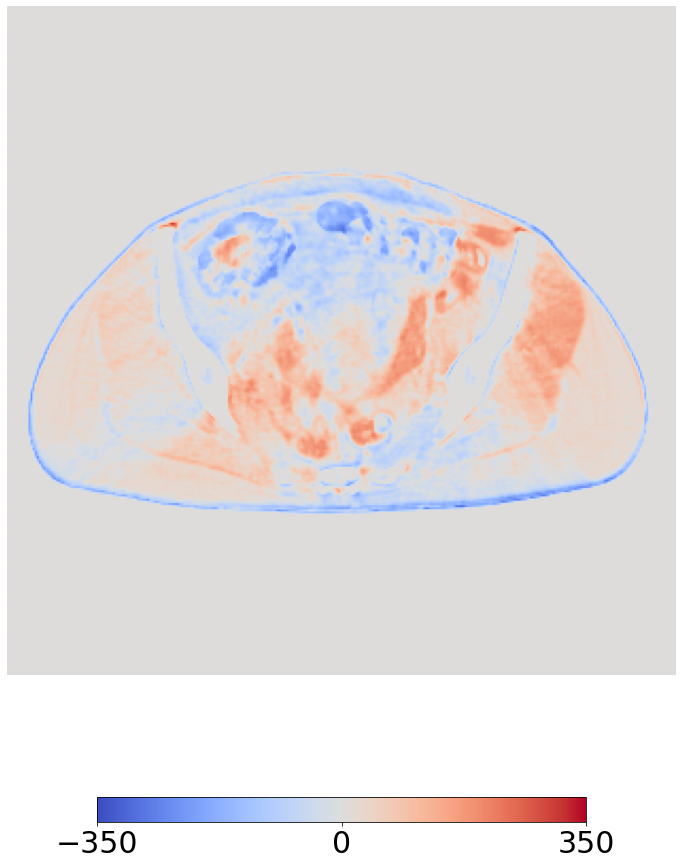

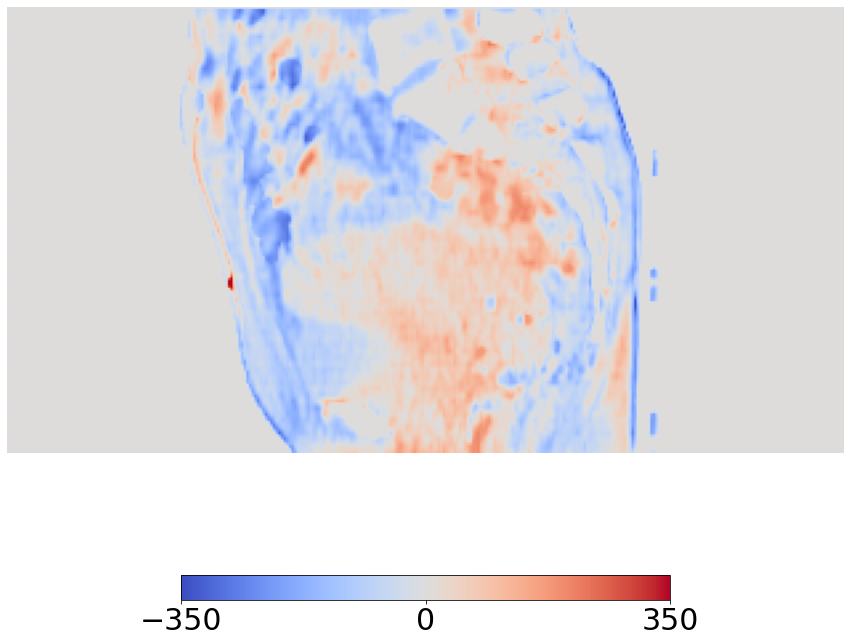

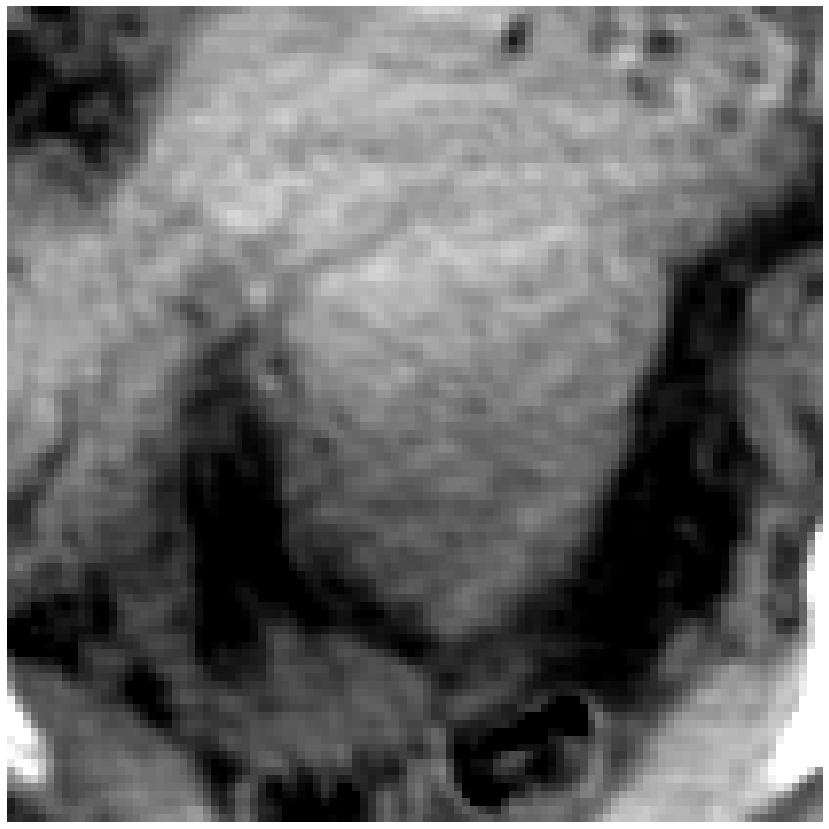

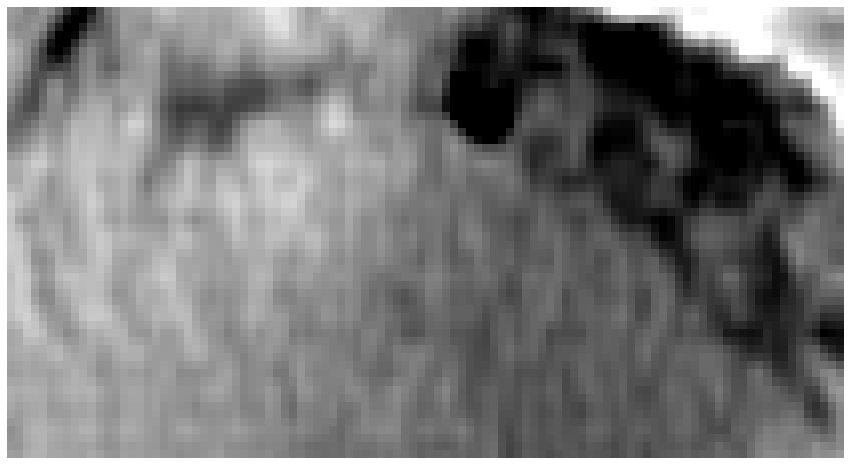

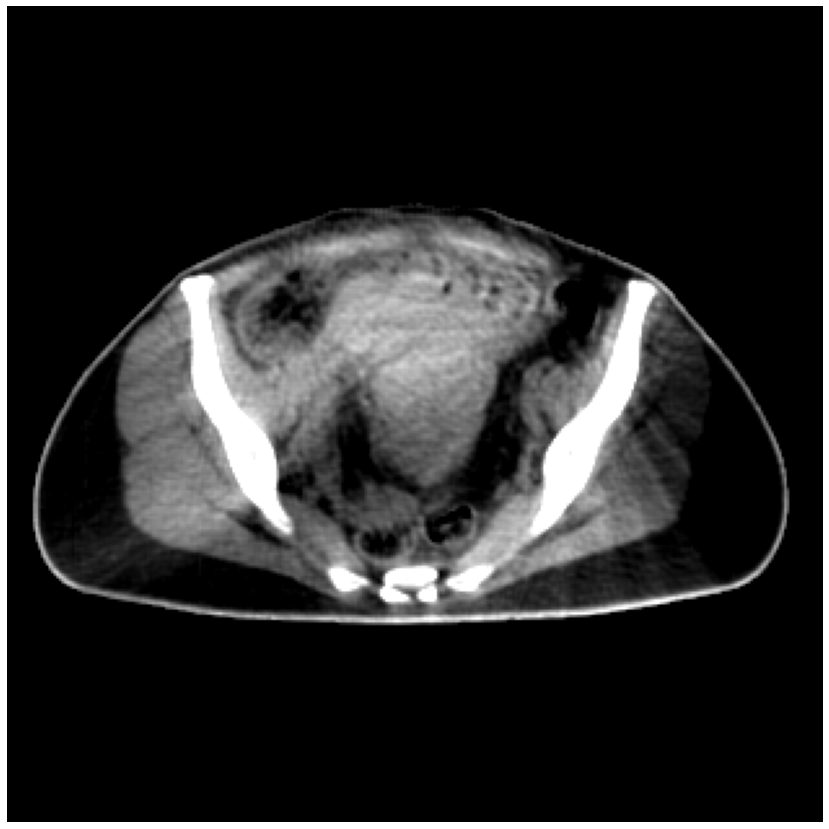

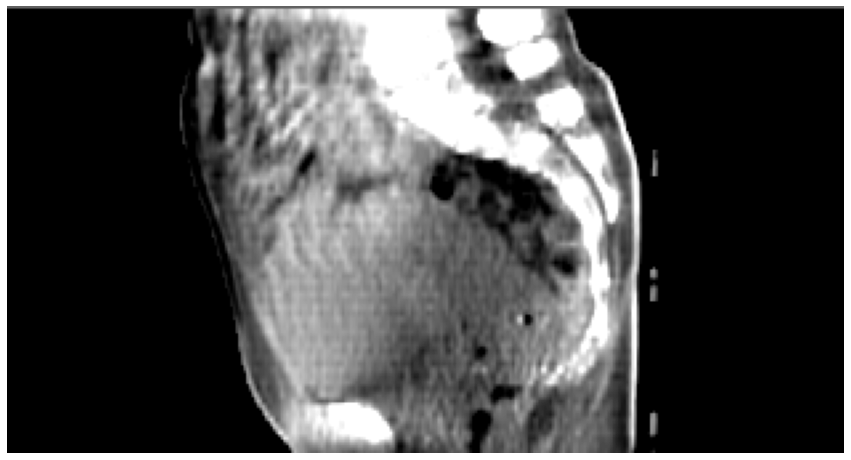

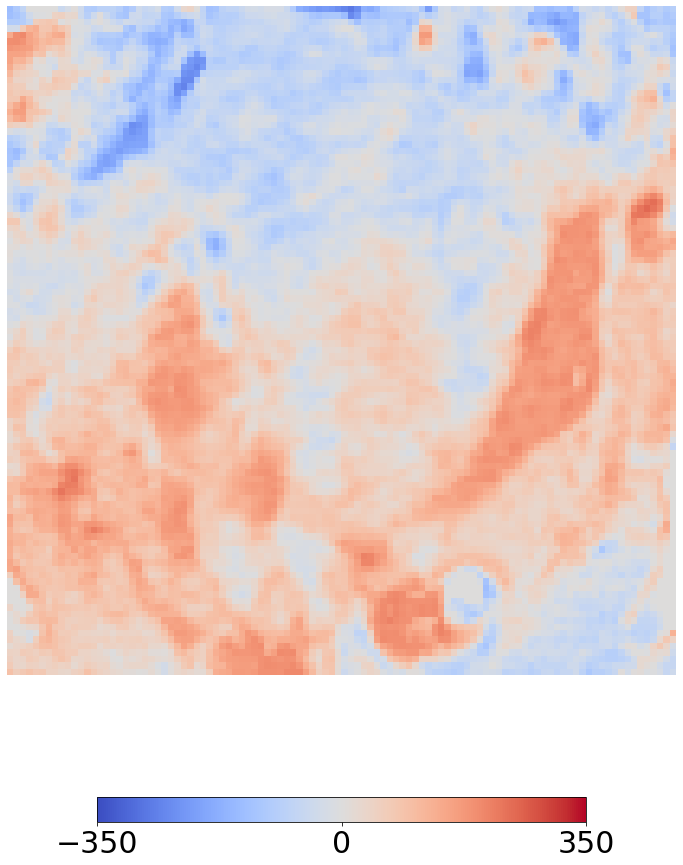

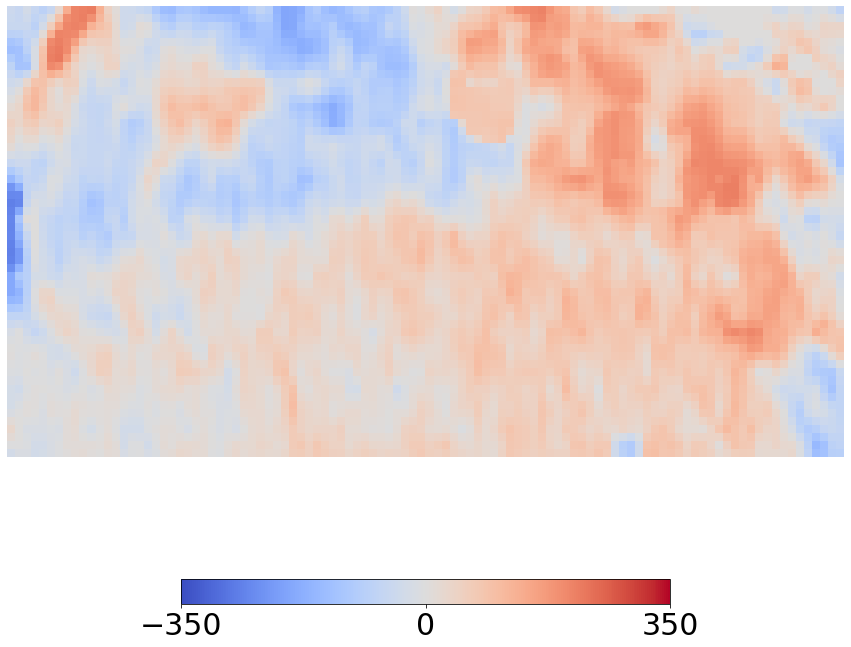

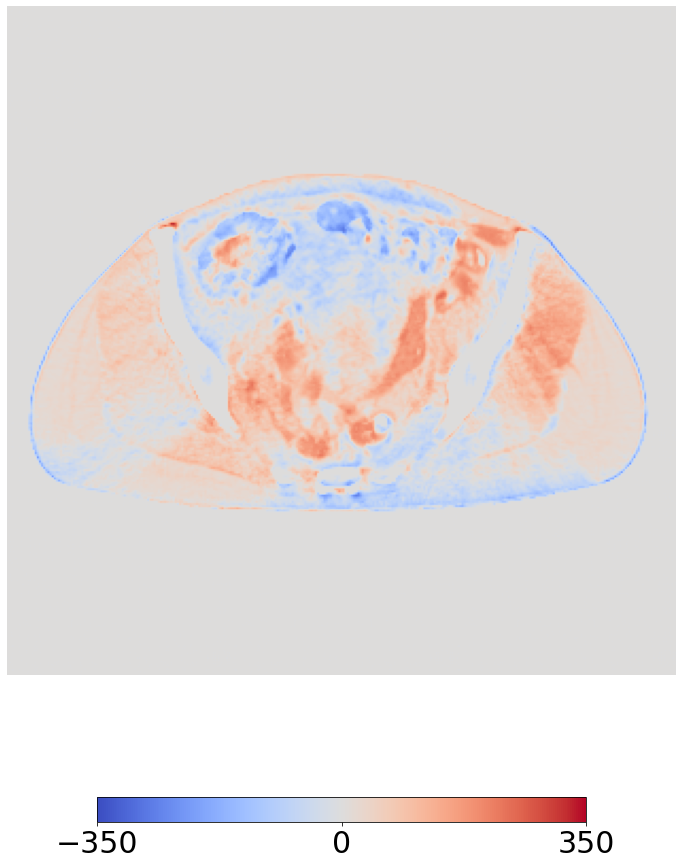

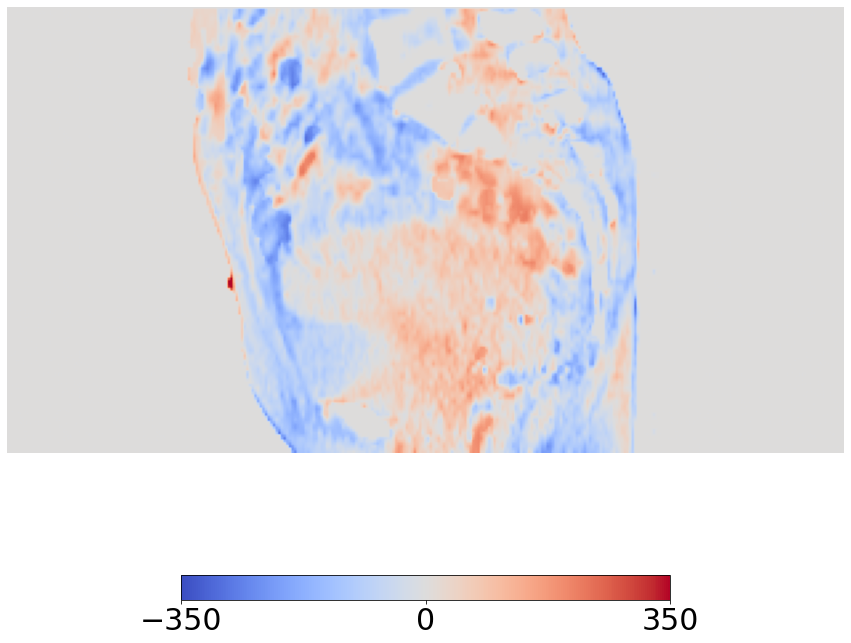

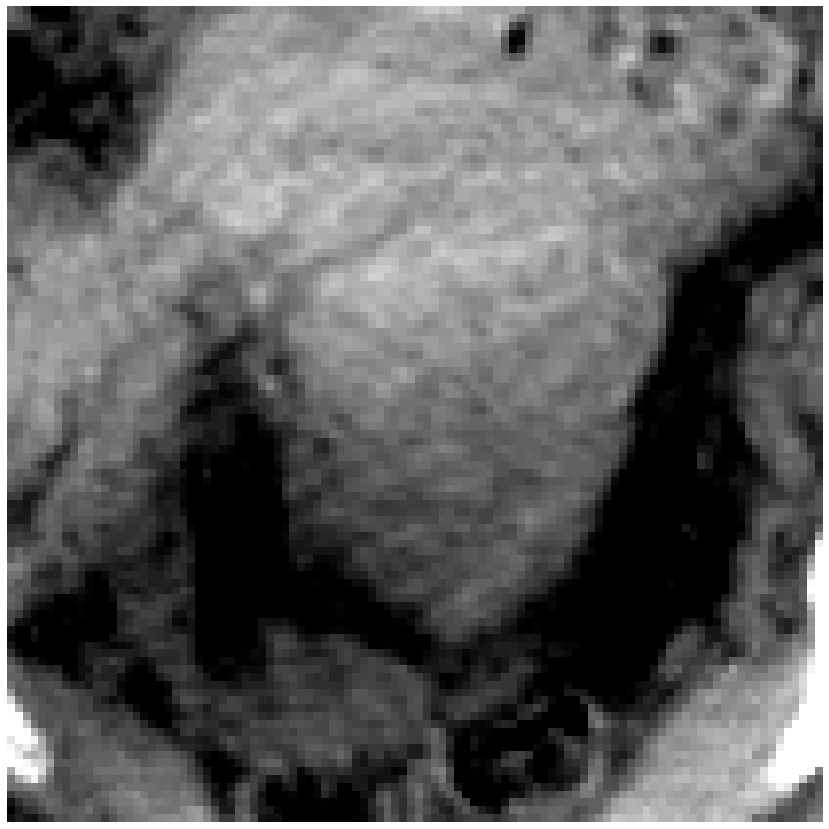

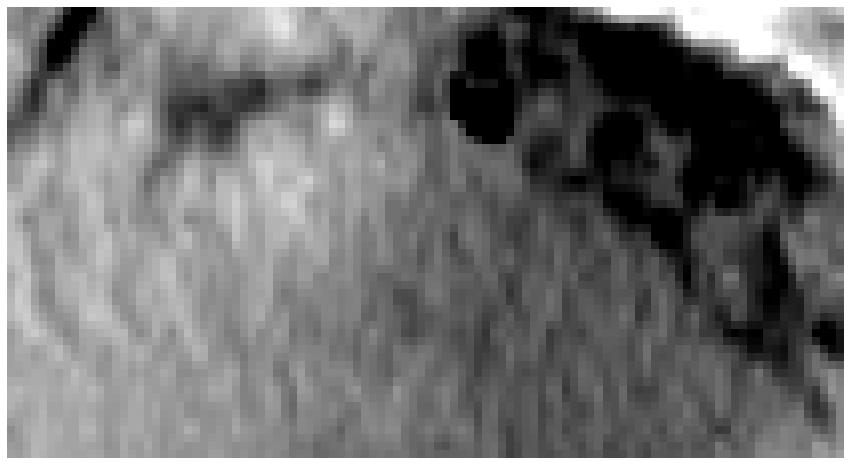

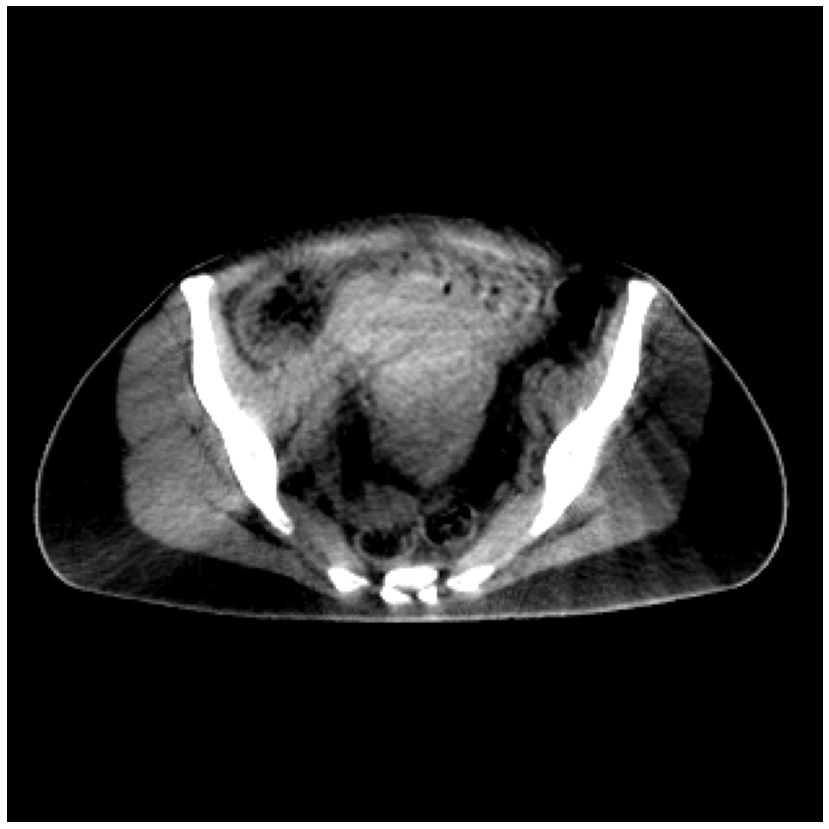

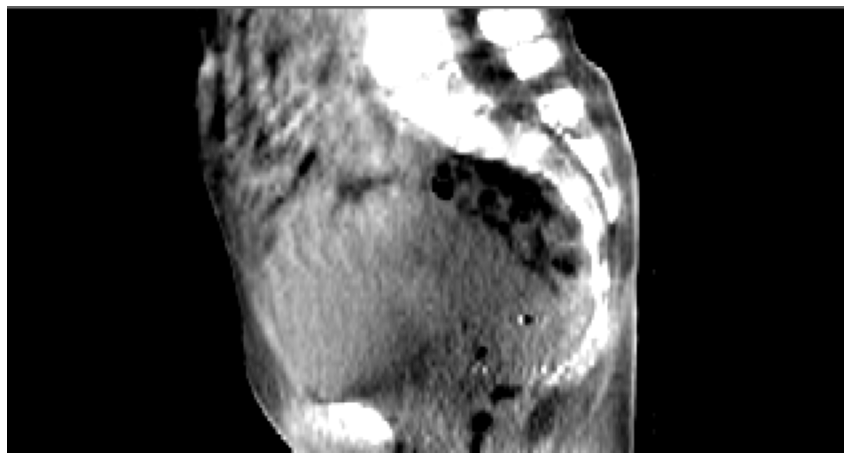

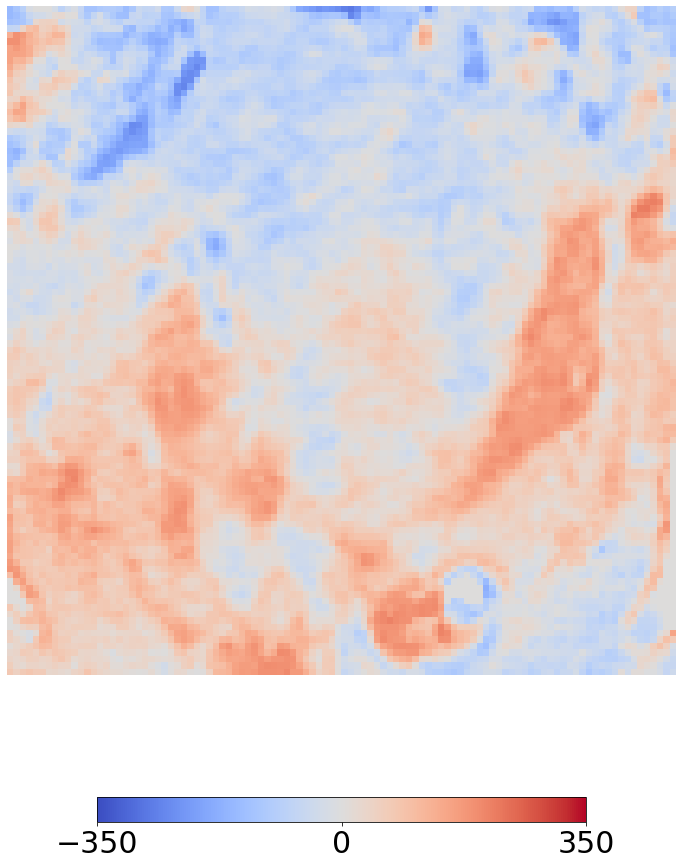

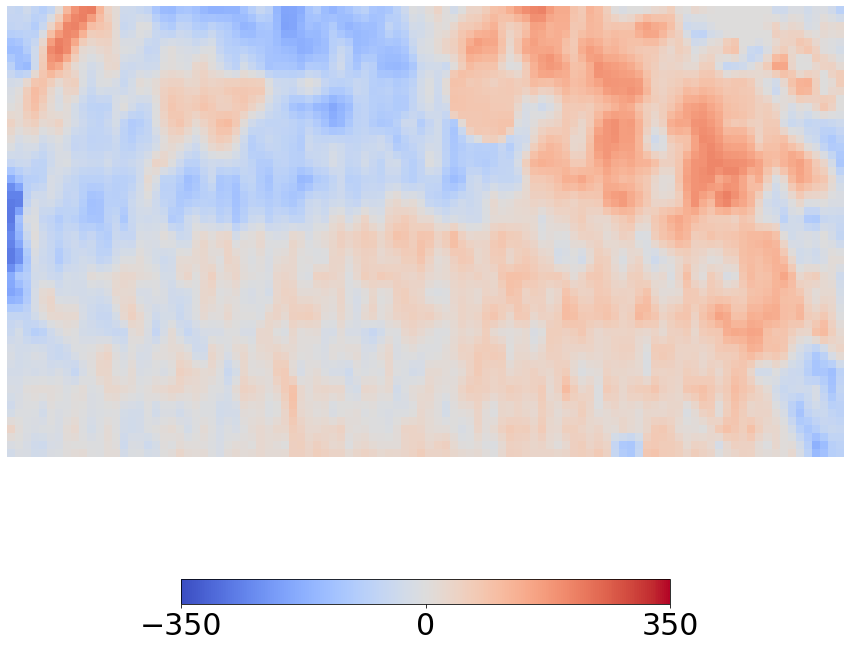

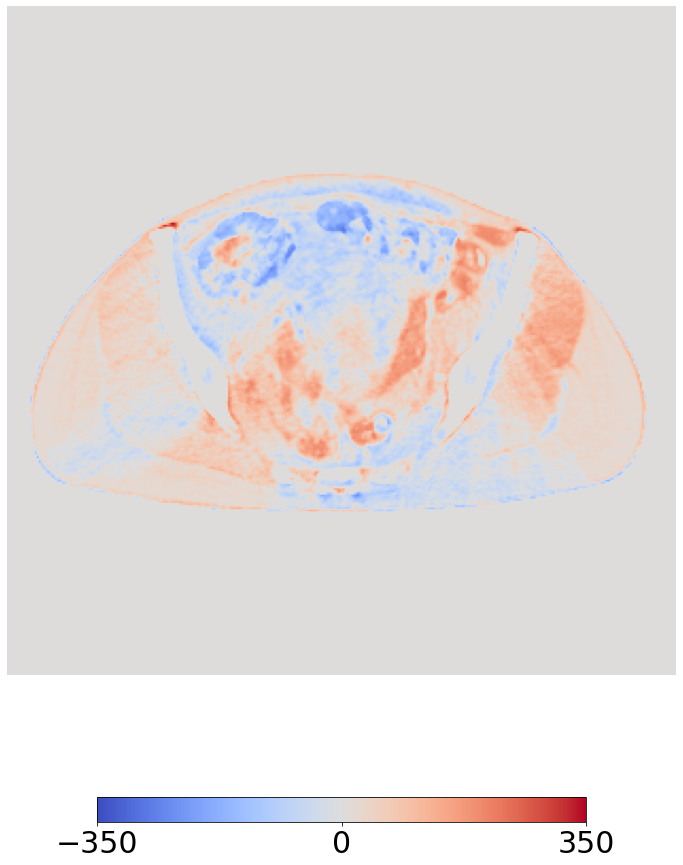

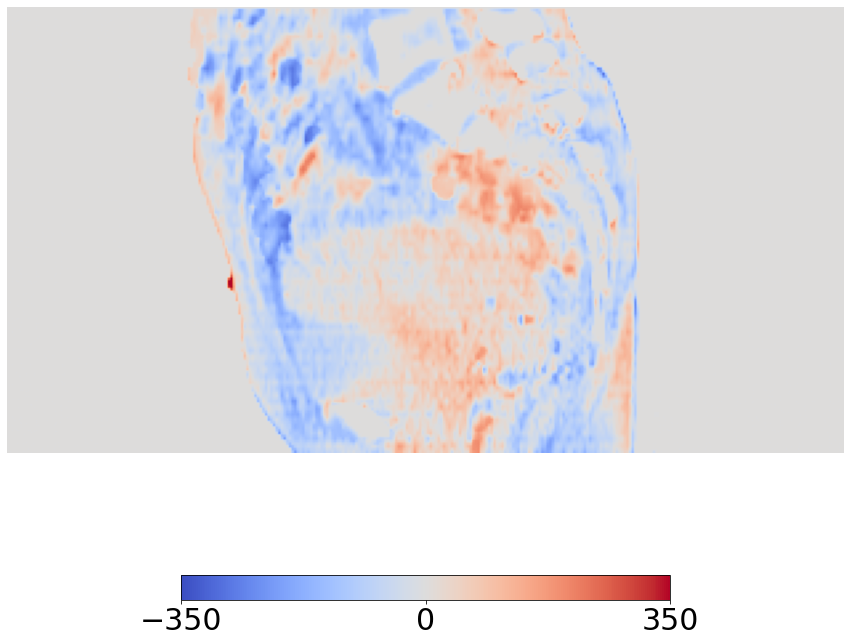

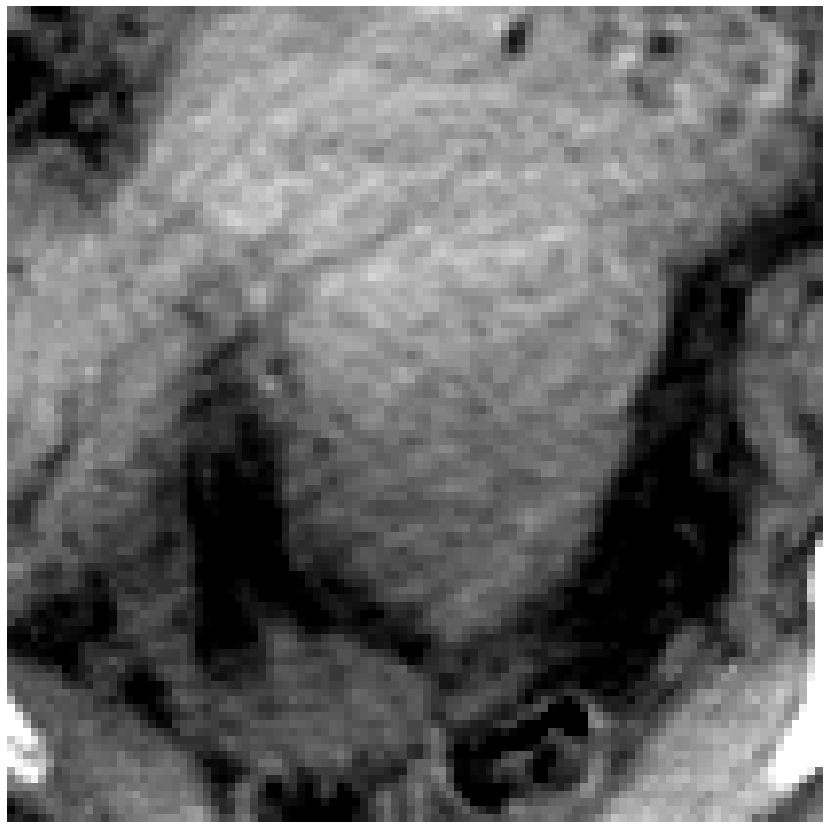

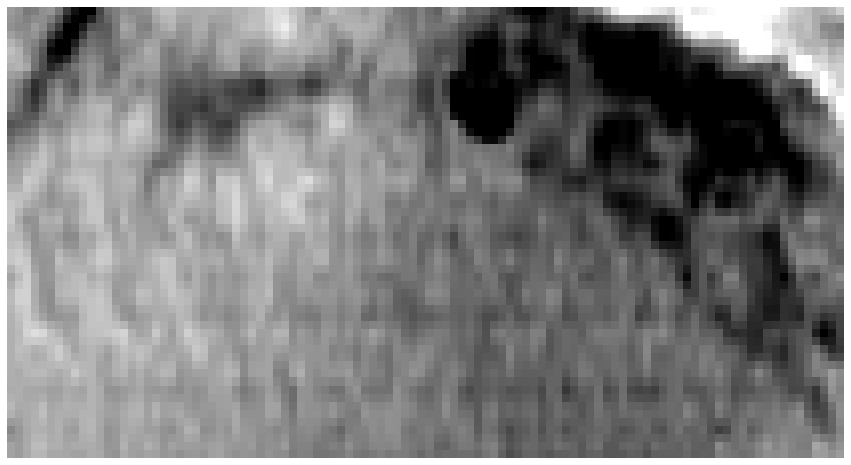

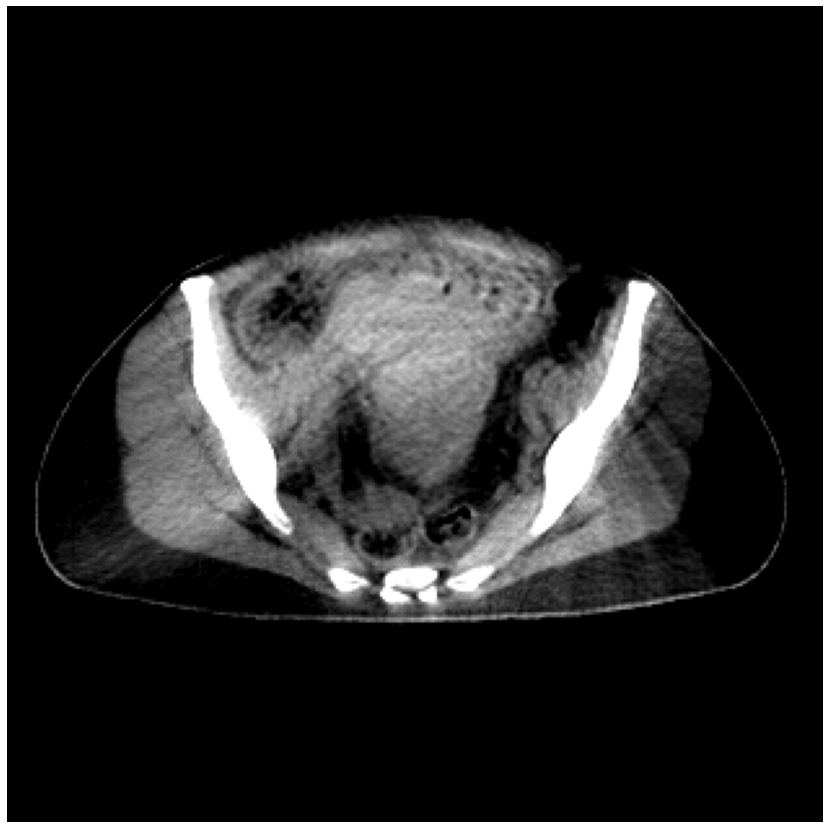

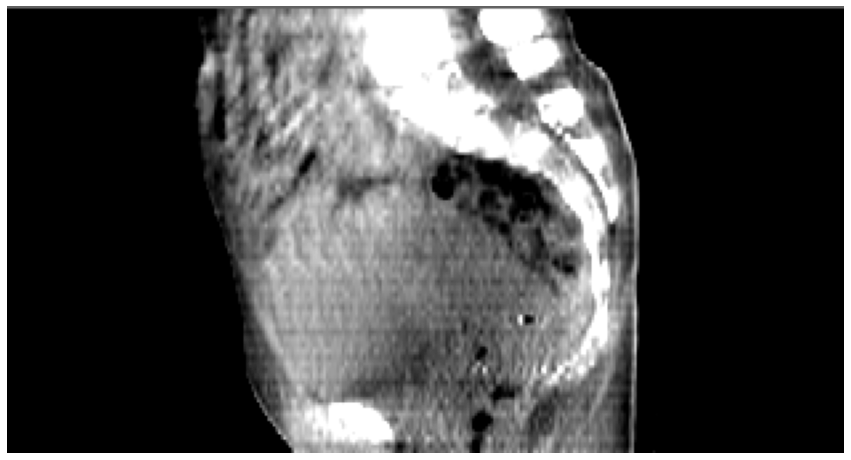

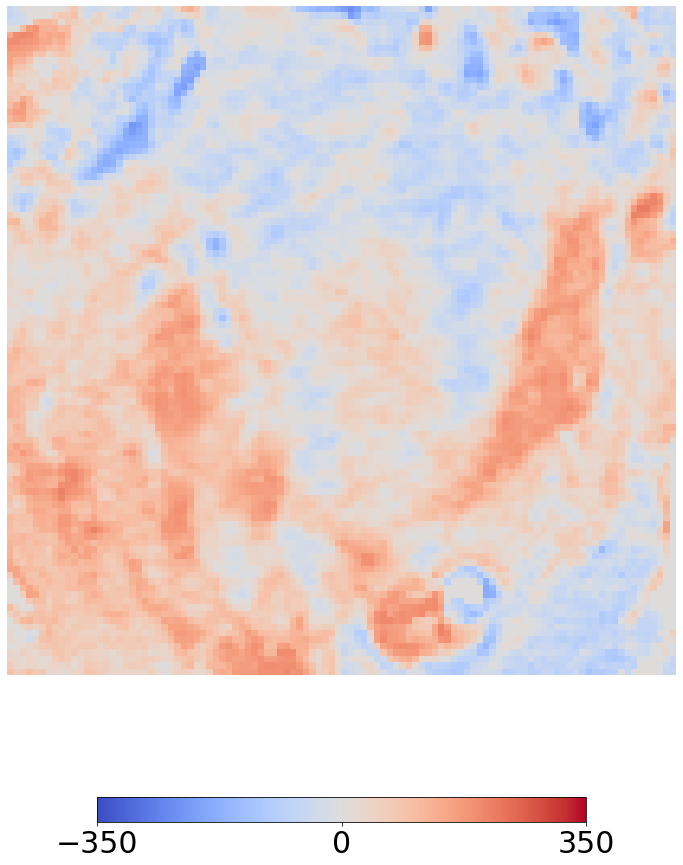

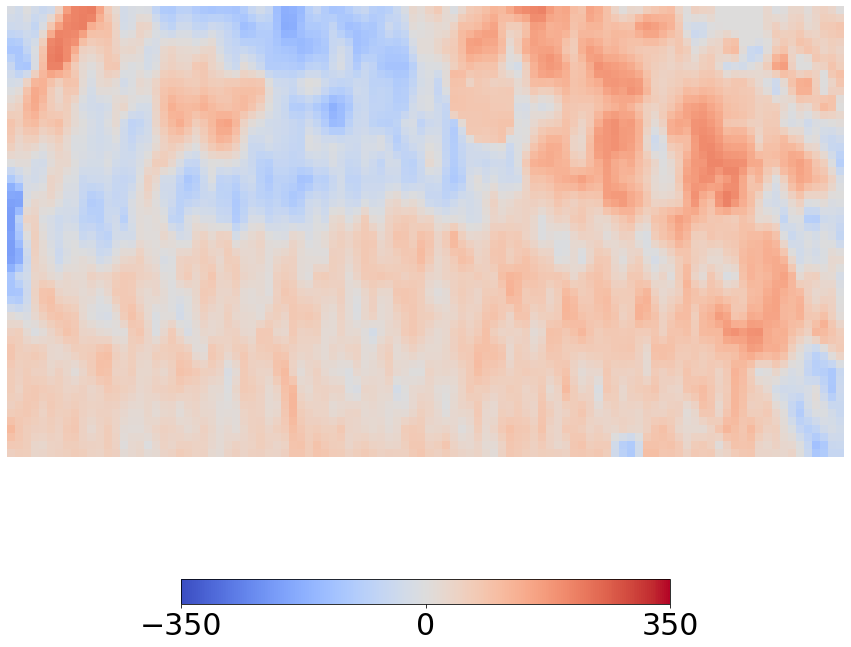

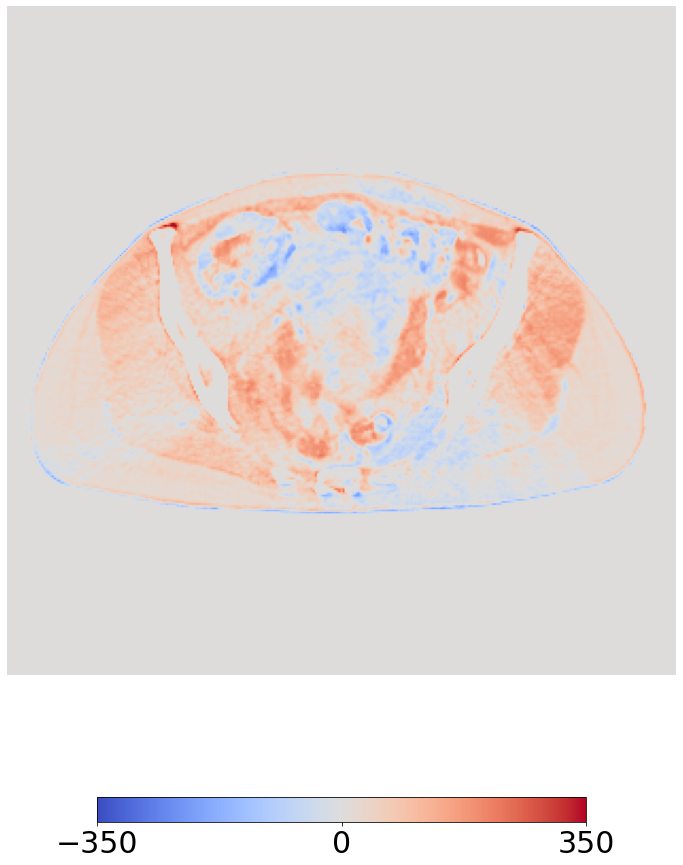

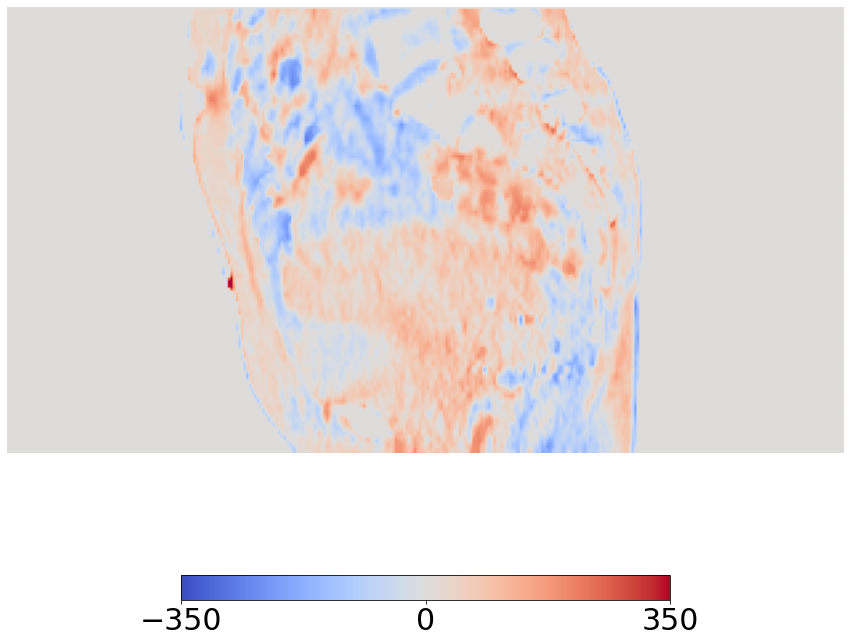

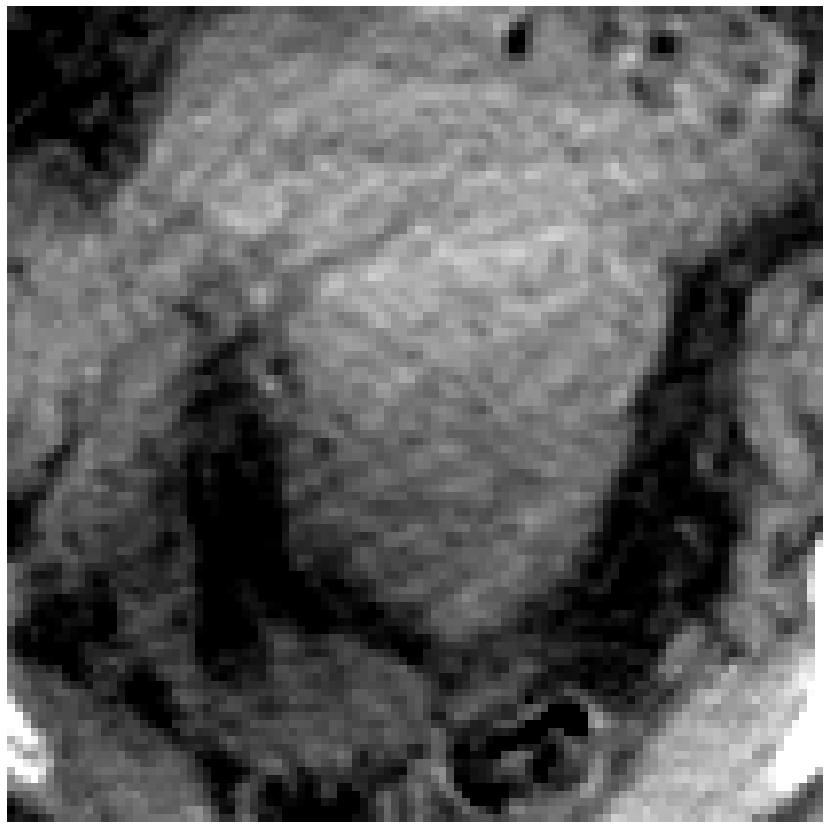

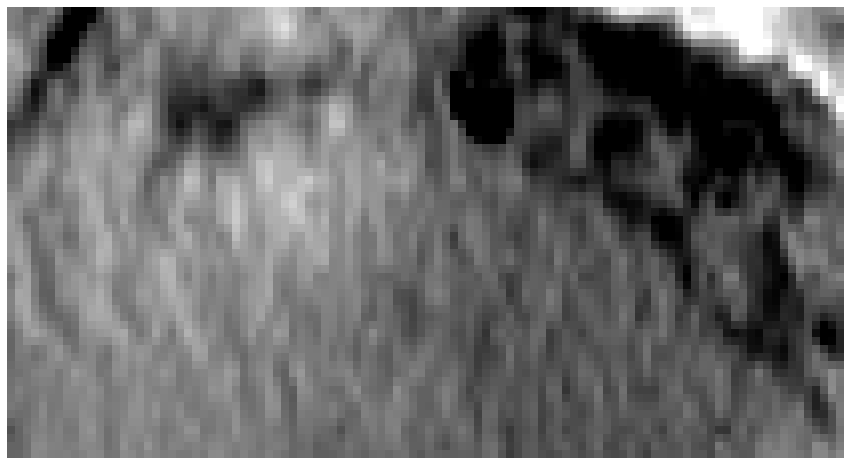

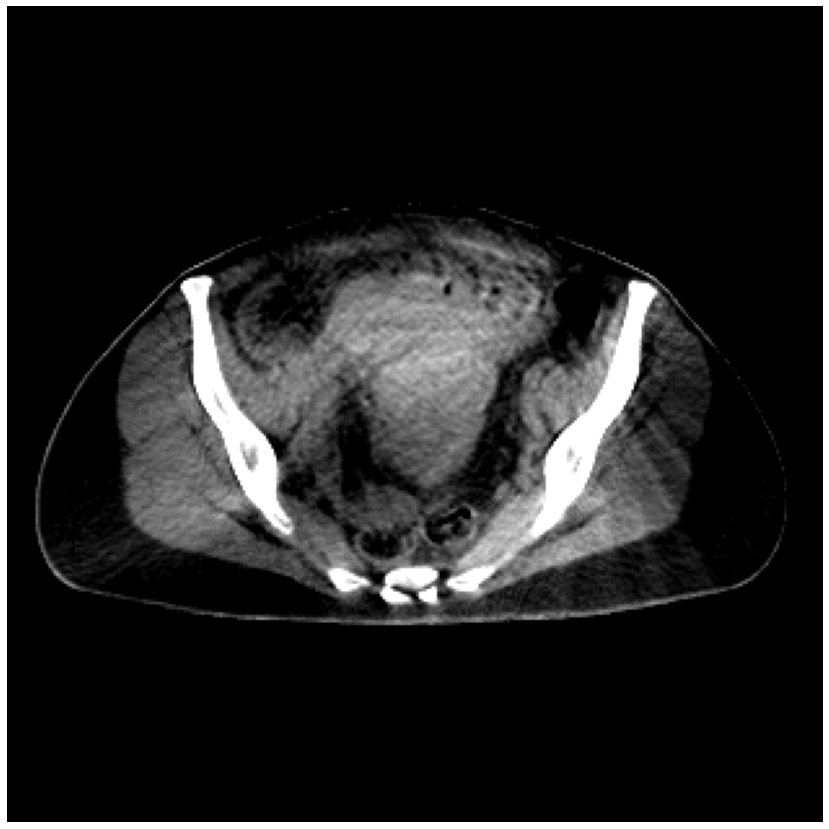

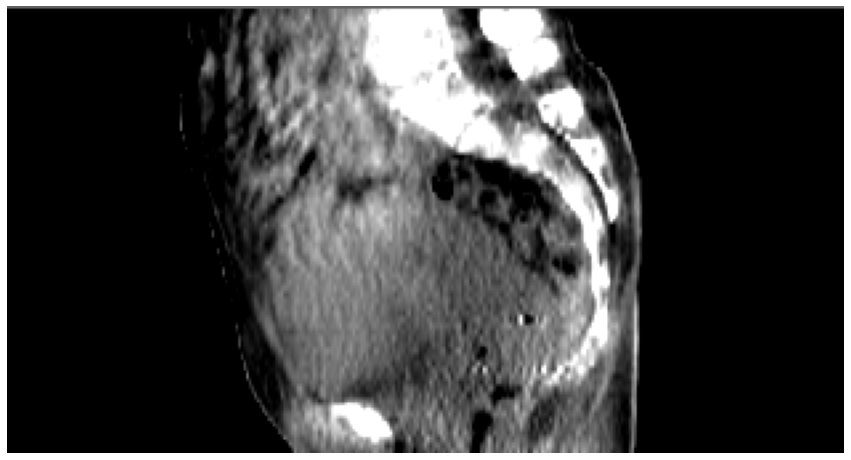

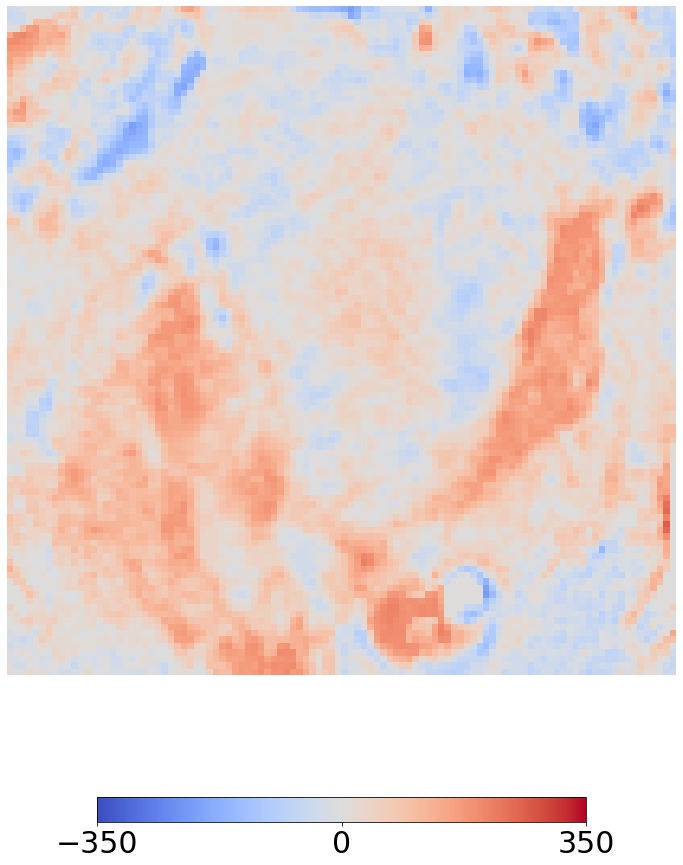

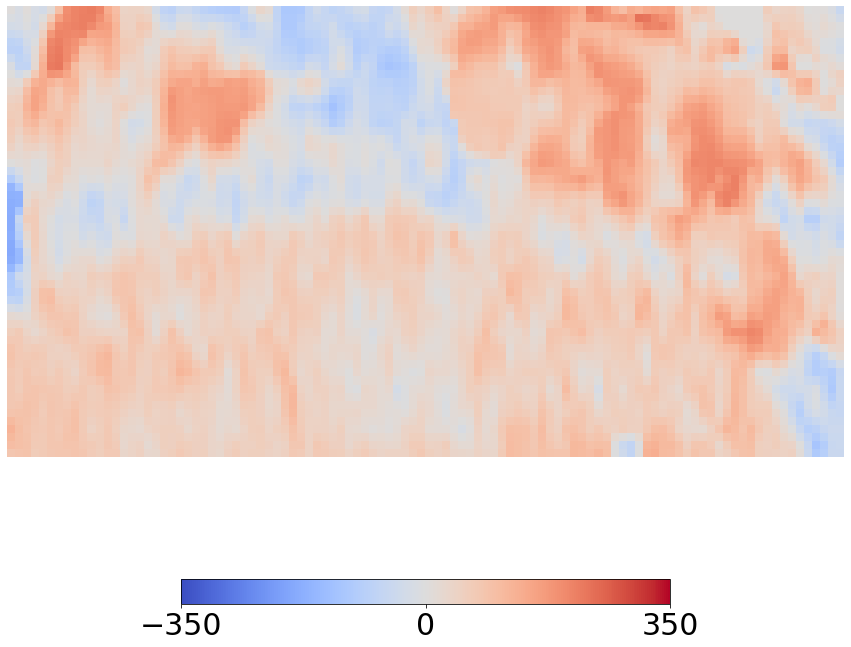

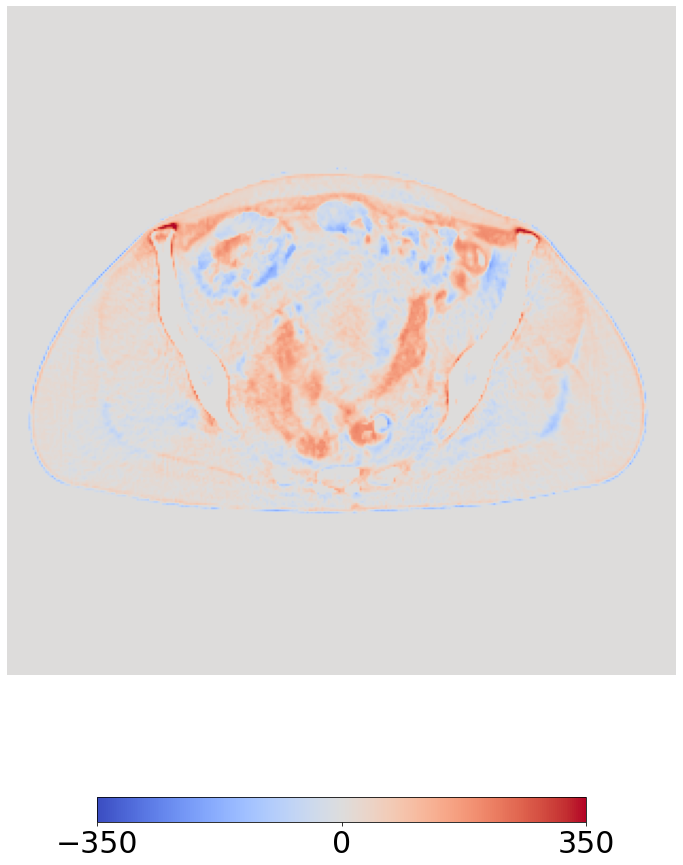

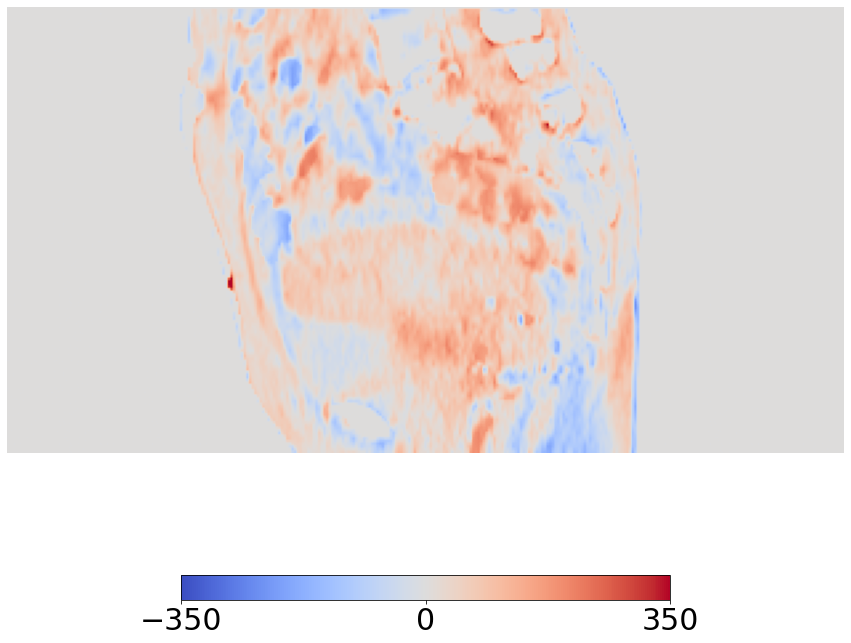

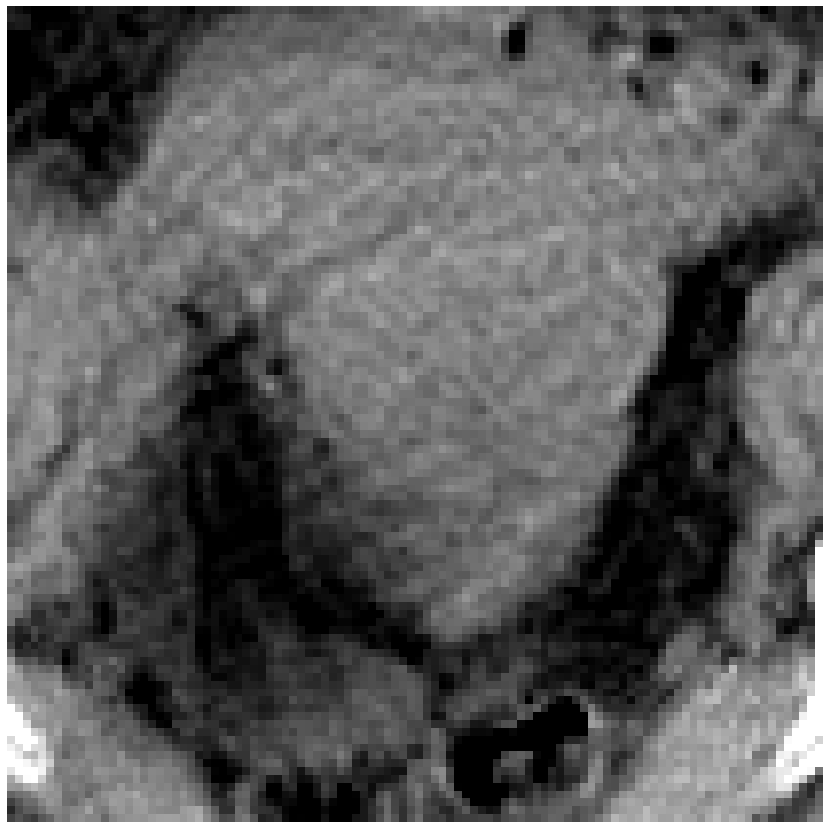

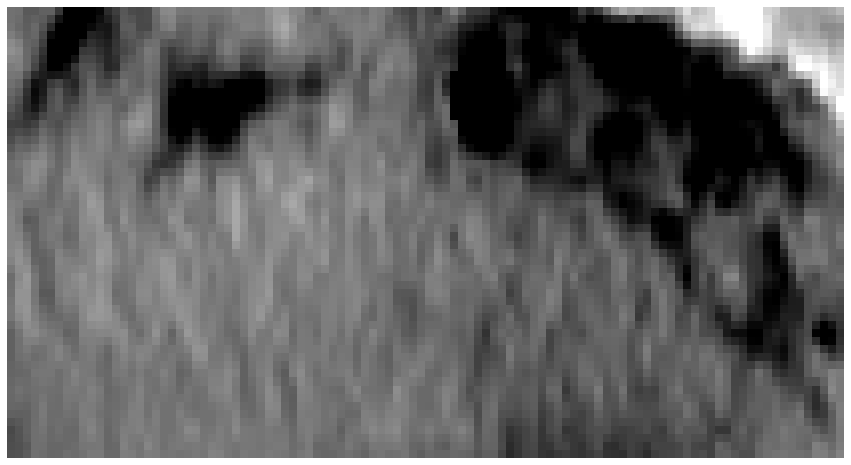

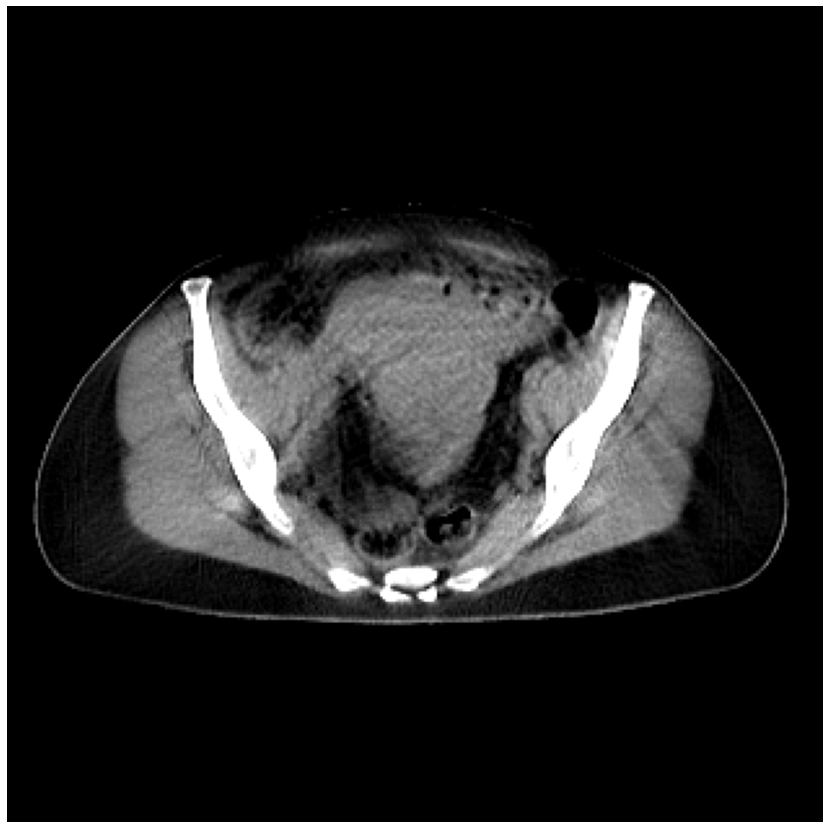

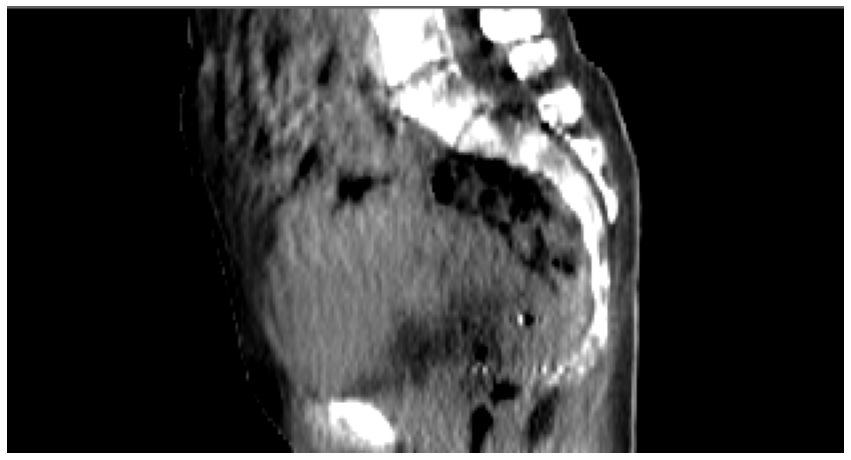

In [3]:
data_folder = Path("/home/suraj/Workspace/results/NKI/media_results/test_predictions").resolve()
patient = "21902070"
save_path = "/home/suraj/Workspace/results/NKI/media_results/paper_qualitative_images/supplementary/patient2"

data_folder = [folder for folder in sorted(data_folder.iterdir()) if folder.is_dir()]

for idx, model in enumerate(data_folder):
    folder = model / patient
    
    translated = folder / "translated.nrrd"
    deformed = folder / "deformed.nrrd"
    
    CT = sitk.ReadImage(str(deformed))
    CT = ops.make_isotropic(CT)
    CT = sitk.GetArrayFromImage(CT)

    
    if idx == 0:
        original = folder / "target.nrrd"
        CBCT = sitk.ReadImage(str(original))
        CBCT = ops.make_isotropic(CBCT)
        CBCT = sitk.GetArrayFromImage(CBCT)
        visuals = get_visuals(CT, CBCT)
        save_and_display_visuals(visuals, f"{save_path}/Original")
        
        visuals = get_visuals(CT, CT)
        save_and_display_visuals(visuals, f"{save_path}/Target")


    sCT = sitk.ReadImage(str(translated))
    sCT = ops.make_isotropic(sCT)
    sCT = sitk.GetArrayFromImage(sCT)

    visuals = get_visuals(CT, sCT)
    save_and_display_visuals(visuals, f"{save_path}/{model.stem}")